In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1755717, 304)
(1755717, 3)
validation
(308504, 304)
(308504, 3)
test
(223783, 304)
(223783, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1001731 (3.82 MB)


Trainable params: 1001731 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/176 [..............................] - ETA: 3:29 - loss: 1.2446 - STD: 0.1329 - MAE: 0.4587

  6/176 [>.............................] - ETA: 1s - loss: 1.1383 - STD: 0.1359 - MAE: 0.4318  

 11/176 [>.............................] - ETA: 1s - loss: 1.1136 - STD: 0.1040 - MAE: 0.4334

 16/176 [=>............................] - ETA: 1s - loss: 1.1030 - STD: 0.0899 - MAE: 0.4344

 21/176 [==>...........................] - ETA: 1s - loss: 1.0964 - STD: 0.0918 - MAE: 0.4332

 26/176 [===>..........................] - ETA: 1s - loss: 1.0905 - STD: 0.0903 - MAE: 0.4325

 31/176 [====>.........................] - ETA: 1s - loss: 1.0851 - STD: 0.0849 - MAE: 0.4324

 36/176 [=====>........................] - ETA: 1s - loss: 1.0774 - STD: 0.0845 - MAE: 0.4308

 41/176 [=====>........................] - ETA: 1s - loss: 1.0662 - STD: 0.0877 - MAE: 0.4276

 46/176 [======>.......................] - ETA: 3s - loss: 1.0529 - STD: 0.0947 - MAE: 0.4227

 51/176 [=======>......................] - ETA: 2s - loss: 1.0387 - STD: 0.1050 - MAE: 0.4167

 56/176 [========>.....................] - ETA: 2s - loss: 1.0264 - STD: 0.1154 - MAE: 0.4107

 61/176 [=========>....................] - ETA: 2s - loss: 1.0152 - STD: 0.1228 - MAE: 0.4061

 66/176 [==========>...................] - ETA: 2s - loss: 1.0052 - STD: 0.1283 - MAE: 0.4024

 71/176 [===========>..................] - ETA: 2s - loss: 0.9953 - STD: 0.1339 - MAE: 0.3987

 76/176 [===========>..................] - ETA: 1s - loss: 0.9865 - STD: 0.1397 - MAE: 0.3949

 81/176 [============>.................] - ETA: 1s - loss: 0.9782 - STD: 0.1448 - MAE: 0.3914

 86/176 [=============>................] - ETA: 1s - loss: 0.9703 - STD: 0.1495 - MAE: 0.3882

 91/176 [==============>...............] - ETA: 1s - loss: 0.9631 - STD: 0.1538 - MAE: 0.3852

 96/176 [===============>..............] - ETA: 1s - loss: 0.9563 - STD: 0.1577 - MAE: 0.3824

101/176 [================>.............] - ETA: 1s - loss: 0.9498 - STD: 0.1619 - MAE: 0.3796

106/176 [=================>............] - ETA: 1s - loss: 0.9439 - STD: 0.1652 - MAE: 0.3772

111/176 [=================>............] - ETA: 1s - loss: 0.9383 - STD: 0.1687 - MAE: 0.3748

116/176 [==================>...........] - ETA: 0s - loss: 0.9329 - STD: 0.1718 - MAE: 0.3725

121/176 [===================>..........] - ETA: 0s - loss: 0.9281 - STD: 0.1749 - MAE: 0.3704

126/176 [====================>.........] - ETA: 0s - loss: 0.9234 - STD: 0.1775 - MAE: 0.3685

131/176 [=====================>........] - ETA: 0s - loss: 0.9191 - STD: 0.1802 - MAE: 0.3666

136/176 [======================>.......] - ETA: 0s - loss: 0.9150 - STD: 0.1828 - MAE: 0.3648

141/176 [=======================>......] - ETA: 0s - loss: 0.9113 - STD: 0.1850 - MAE: 0.3632

146/176 [=======================>......] - ETA: 0s - loss: 0.9076 - STD: 0.1871 - MAE: 0.3617

151/176 [========================>.....] - ETA: 0s - loss: 0.9040 - STD: 0.1892 - MAE: 0.3602

156/176 [=========================>....] - ETA: 0s - loss: 0.9009 - STD: 0.1913 - MAE: 0.3587

161/176 [==========================>...] - ETA: 0s - loss: 0.8977 - STD: 0.1930 - MAE: 0.3574

166/176 [===========================>..] - ETA: 0s - loss: 0.8947 - STD: 0.1948 - MAE: 0.3561

171/176 [============================>.] - ETA: 0s - loss: 0.8917 - STD: 0.1966 - MAE: 0.3548

176/176 [==============================] - ETA: 0s - loss: 0.8888 - STD: 0.1983 - MAE: 0.3536

176/176 [==============================] - 5s 19ms/step - loss: 0.8888 - STD: 0.1983 - MAE: 0.3536 - val_loss: 0.7995 - val_STD: 0.2652 - val_MAE: 0.3061


Epoch 2/10000


  1/176 [..............................] - ETA: 6s - loss: 0.7795 - STD: 0.2547 - MAE: 0.3097

  6/176 [>.............................] - ETA: 1s - loss: 0.7914 - STD: 0.2557 - MAE: 0.3115

 11/176 [>.............................] - ETA: 1s - loss: 0.7912 - STD: 0.2558 - MAE: 0.3114

 16/176 [=>............................] - ETA: 1s - loss: 0.7903 - STD: 0.2566 - MAE: 0.3108

 21/176 [==>...........................] - ETA: 1s - loss: 0.7887 - STD: 0.2566 - MAE: 0.3105

 26/176 [===>..........................] - ETA: 1s - loss: 0.7883 - STD: 0.2578 - MAE: 0.3098

 31/176 [====>.........................] - ETA: 1s - loss: 0.7876 - STD: 0.2577 - MAE: 0.3097

 36/176 [=====>........................] - ETA: 1s - loss: 0.7854 - STD: 0.2584 - MAE: 0.3088

 41/176 [=====>........................] - ETA: 1s - loss: 0.7832 - STD: 0.2595 - MAE: 0.3078

 46/176 [======>.......................] - ETA: 1s - loss: 0.7815 - STD: 0.2604 - MAE: 0.3070

 51/176 [=======>......................] - ETA: 1s - loss: 0.7805 - STD: 0.2610 - MAE: 0.3064

 56/176 [========>.....................] - ETA: 1s - loss: 0.7792 - STD: 0.2615 - MAE: 0.3059

 61/176 [=========>....................] - ETA: 1s - loss: 0.7779 - STD: 0.2622 - MAE: 0.3053

 66/176 [==========>...................] - ETA: 1s - loss: 0.7773 - STD: 0.2624 - MAE: 0.3050

 71/176 [===========>..................] - ETA: 1s - loss: 0.7768 - STD: 0.2627 - MAE: 0.3048

 76/176 [===========>..................] - ETA: 1s - loss: 0.7757 - STD: 0.2633 - MAE: 0.3043

 81/176 [============>.................] - ETA: 1s - loss: 0.7748 - STD: 0.2638 - MAE: 0.3038

 86/176 [=============>................] - ETA: 0s - loss: 0.7740 - STD: 0.2640 - MAE: 0.3036

 91/176 [==============>...............] - ETA: 0s - loss: 0.7732 - STD: 0.2644 - MAE: 0.3032

 96/176 [===============>..............] - ETA: 0s - loss: 0.7721 - STD: 0.2647 - MAE: 0.3028

101/176 [================>.............] - ETA: 0s - loss: 0.7712 - STD: 0.2652 - MAE: 0.3024

106/176 [=================>............] - ETA: 0s - loss: 0.7703 - STD: 0.2655 - MAE: 0.3020

111/176 [=================>............] - ETA: 0s - loss: 0.7698 - STD: 0.2658 - MAE: 0.3018

116/176 [==================>...........] - ETA: 0s - loss: 0.7693 - STD: 0.2661 - MAE: 0.3015

121/176 [===================>..........] - ETA: 0s - loss: 0.7685 - STD: 0.2663 - MAE: 0.3013

126/176 [====================>.........] - ETA: 0s - loss: 0.7677 - STD: 0.2666 - MAE: 0.3010

131/176 [=====================>........] - ETA: 0s - loss: 0.7670 - STD: 0.2669 - MAE: 0.3007

136/176 [======================>.......] - ETA: 0s - loss: 0.7664 - STD: 0.2672 - MAE: 0.3004

141/176 [=======================>......] - ETA: 0s - loss: 0.7660 - STD: 0.2675 - MAE: 0.3002

146/176 [=======================>......] - ETA: 0s - loss: 0.7656 - STD: 0.2677 - MAE: 0.3000

151/176 [========================>.....] - ETA: 0s - loss: 0.7651 - STD: 0.2678 - MAE: 0.2999

156/176 [=========================>....] - ETA: 0s - loss: 0.7644 - STD: 0.2680 - MAE: 0.2996

161/176 [==========================>...] - ETA: 0s - loss: 0.7637 - STD: 0.2683 - MAE: 0.2993

166/176 [===========================>..] - ETA: 0s - loss: 0.7629 - STD: 0.2686 - MAE: 0.2990

171/176 [============================>.] - ETA: 0s - loss: 0.7621 - STD: 0.2688 - MAE: 0.2987

176/176 [==============================] - ETA: 0s - loss: 0.7616 - STD: 0.2691 - MAE: 0.2985

176/176 [==============================] - 2s 12ms/step - loss: 0.7616 - STD: 0.2691 - MAE: 0.2985 - val_loss: 0.7537 - val_STD: 0.2979 - val_MAE: 0.2807


Epoch 3/10000


  1/176 [..............................] - ETA: 5s - loss: 0.7424 - STD: 0.2779 - MAE: 0.2903

  6/176 [>.............................] - ETA: 1s - loss: 0.7444 - STD: 0.2758 - MAE: 0.2919

 11/176 [>.............................] - ETA: 1s - loss: 0.7436 - STD: 0.2755 - MAE: 0.2919

 16/176 [=>............................] - ETA: 1s - loss: 0.7409 - STD: 0.2757 - MAE: 0.2912

 21/176 [==>...........................] - ETA: 1s - loss: 0.7403 - STD: 0.2765 - MAE: 0.2907

 26/176 [===>..........................] - ETA: 1s - loss: 0.7384 - STD: 0.2773 - MAE: 0.2899

 31/176 [====>.........................] - ETA: 1s - loss: 0.7363 - STD: 0.2776 - MAE: 0.2893

 36/176 [=====>........................] - ETA: 1s - loss: 0.7355 - STD: 0.2780 - MAE: 0.2889

 41/176 [=====>........................] - ETA: 1s - loss: 0.7350 - STD: 0.2783 - MAE: 0.2887

 46/176 [======>.......................] - ETA: 1s - loss: 0.7345 - STD: 0.2783 - MAE: 0.2885

 51/176 [=======>......................] - ETA: 1s - loss: 0.7344 - STD: 0.2788 - MAE: 0.2883

 56/176 [========>.....................] - ETA: 1s - loss: 0.7342 - STD: 0.2790 - MAE: 0.2881

 61/176 [=========>....................] - ETA: 1s - loss: 0.7333 - STD: 0.2790 - MAE: 0.2879

 66/176 [==========>...................] - ETA: 1s - loss: 0.7331 - STD: 0.2793 - MAE: 0.2877

 71/176 [===========>..................] - ETA: 1s - loss: 0.7327 - STD: 0.2792 - MAE: 0.2877

 76/176 [===========>..................] - ETA: 1s - loss: 0.7325 - STD: 0.2795 - MAE: 0.2875

 81/176 [============>.................] - ETA: 1s - loss: 0.7321 - STD: 0.2796 - MAE: 0.2874

 86/176 [=============>................] - ETA: 0s - loss: 0.7315 - STD: 0.2799 - MAE: 0.2871

 91/176 [==============>...............] - ETA: 0s - loss: 0.7309 - STD: 0.2801 - MAE: 0.2869

 96/176 [===============>..............] - ETA: 0s - loss: 0.7312 - STD: 0.2804 - MAE: 0.2868

101/176 [================>.............] - ETA: 0s - loss: 0.7314 - STD: 0.2807 - MAE: 0.2867

106/176 [=================>............] - ETA: 0s - loss: 0.7312 - STD: 0.2808 - MAE: 0.2866

111/176 [=================>............] - ETA: 0s - loss: 0.7311 - STD: 0.2807 - MAE: 0.2866

116/176 [==================>...........] - ETA: 0s - loss: 0.7305 - STD: 0.2808 - MAE: 0.2864

121/176 [===================>..........] - ETA: 0s - loss: 0.7302 - STD: 0.2808 - MAE: 0.2864

126/176 [====================>.........] - ETA: 0s - loss: 0.7298 - STD: 0.2810 - MAE: 0.2862

131/176 [=====================>........] - ETA: 0s - loss: 0.7292 - STD: 0.2812 - MAE: 0.2860

136/176 [======================>.......] - ETA: 0s - loss: 0.7287 - STD: 0.2813 - MAE: 0.2858

141/176 [=======================>......] - ETA: 0s - loss: 0.7285 - STD: 0.2813 - MAE: 0.2857

146/176 [=======================>......] - ETA: 0s - loss: 0.7281 - STD: 0.2815 - MAE: 0.2856

151/176 [========================>.....] - ETA: 0s - loss: 0.7278 - STD: 0.2817 - MAE: 0.2854

156/176 [=========================>....] - ETA: 0s - loss: 0.7275 - STD: 0.2817 - MAE: 0.2853

161/176 [==========================>...] - ETA: 0s - loss: 0.7271 - STD: 0.2819 - MAE: 0.2852

166/176 [===========================>..] - ETA: 0s - loss: 0.7266 - STD: 0.2819 - MAE: 0.2850

171/176 [============================>.] - ETA: 0s - loss: 0.7263 - STD: 0.2821 - MAE: 0.2848

176/176 [==============================] - ETA: 0s - loss: 0.7260 - STD: 0.2822 - MAE: 0.2847

176/176 [==============================] - 2s 12ms/step - loss: 0.7260 - STD: 0.2822 - MAE: 0.2847 - val_loss: 0.7386 - val_STD: 0.3101 - val_MAE: 0.2700


Epoch 4/10000


  1/176 [..............................] - ETA: 5s - loss: 0.7240 - STD: 0.2907 - MAE: 0.2796

  6/176 [>.............................] - ETA: 1s - loss: 0.7157 - STD: 0.2848 - MAE: 0.2812

 11/176 [>.............................] - ETA: 1s - loss: 0.7147 - STD: 0.2854 - MAE: 0.2807

 16/176 [=>............................] - ETA: 1s - loss: 0.7135 - STD: 0.2860 - MAE: 0.2802

 21/176 [==>...........................] - ETA: 1s - loss: 0.7123 - STD: 0.2865 - MAE: 0.2797

 26/176 [===>..........................] - ETA: 1s - loss: 0.7122 - STD: 0.2864 - MAE: 0.2798

 31/176 [====>.........................] - ETA: 1s - loss: 0.7129 - STD: 0.2862 - MAE: 0.2800

 36/176 [=====>........................] - ETA: 1s - loss: 0.7133 - STD: 0.2864 - MAE: 0.2799

 41/176 [=====>........................] - ETA: 1s - loss: 0.7146 - STD: 0.2865 - MAE: 0.2801

 46/176 [======>.......................] - ETA: 1s - loss: 0.7158 - STD: 0.2870 - MAE: 0.2801

 51/176 [=======>......................] - ETA: 1s - loss: 0.7161 - STD: 0.2872 - MAE: 0.2800

 56/176 [========>.....................] - ETA: 1s - loss: 0.7161 - STD: 0.2873 - MAE: 0.2799

 61/176 [=========>....................] - ETA: 1s - loss: 0.7161 - STD: 0.2870 - MAE: 0.2801

 66/176 [==========>...................] - ETA: 1s - loss: 0.7159 - STD: 0.2869 - MAE: 0.2800

 71/176 [===========>..................] - ETA: 1s - loss: 0.7158 - STD: 0.2868 - MAE: 0.2801

 76/176 [===========>..................] - ETA: 1s - loss: 0.7149 - STD: 0.2867 - MAE: 0.2799

 81/176 [============>.................] - ETA: 1s - loss: 0.7146 - STD: 0.2870 - MAE: 0.2797

 86/176 [=============>................] - ETA: 0s - loss: 0.7144 - STD: 0.2870 - MAE: 0.2797

 91/176 [==============>...............] - ETA: 0s - loss: 0.7139 - STD: 0.2871 - MAE: 0.2795

 96/176 [===============>..............] - ETA: 0s - loss: 0.7137 - STD: 0.2872 - MAE: 0.2794

101/176 [================>.............] - ETA: 0s - loss: 0.7133 - STD: 0.2873 - MAE: 0.2793

106/176 [=================>............] - ETA: 0s - loss: 0.7130 - STD: 0.2874 - MAE: 0.2792

111/176 [=================>............] - ETA: 0s - loss: 0.7129 - STD: 0.2874 - MAE: 0.2791

116/176 [==================>...........] - ETA: 0s - loss: 0.7126 - STD: 0.2875 - MAE: 0.2790

121/176 [===================>..........] - ETA: 0s - loss: 0.7124 - STD: 0.2874 - MAE: 0.2791

126/176 [====================>.........] - ETA: 0s - loss: 0.7123 - STD: 0.2874 - MAE: 0.2790

131/176 [=====================>........] - ETA: 0s - loss: 0.7123 - STD: 0.2876 - MAE: 0.2790

136/176 [======================>.......] - ETA: 0s - loss: 0.7122 - STD: 0.2875 - MAE: 0.2790

141/176 [=======================>......] - ETA: 0s - loss: 0.7120 - STD: 0.2877 - MAE: 0.2788

146/176 [=======================>......] - ETA: 0s - loss: 0.7117 - STD: 0.2878 - MAE: 0.2787

151/176 [========================>.....] - ETA: 0s - loss: 0.7113 - STD: 0.2878 - MAE: 0.2786

156/176 [=========================>....] - ETA: 0s - loss: 0.7112 - STD: 0.2879 - MAE: 0.2785

161/176 [==========================>...] - ETA: 0s - loss: 0.7110 - STD: 0.2880 - MAE: 0.2785

166/176 [===========================>..] - ETA: 0s - loss: 0.7107 - STD: 0.2879 - MAE: 0.2784

171/176 [============================>.] - ETA: 0s - loss: 0.7105 - STD: 0.2880 - MAE: 0.2784

176/176 [==============================] - ETA: 0s - loss: 0.7104 - STD: 0.2880 - MAE: 0.2783

176/176 [==============================] - 2s 12ms/step - loss: 0.7104 - STD: 0.2880 - MAE: 0.2783 - val_loss: 0.7323 - val_STD: 0.3077 - val_MAE: 0.2690


Epoch 5/10000


  1/176 [..............................] - ETA: 5s - loss: 0.7025 - STD: 0.2894 - MAE: 0.2760

  6/176 [>.............................] - ETA: 1s - loss: 0.6990 - STD: 0.2898 - MAE: 0.2752

 11/176 [>.............................] - ETA: 1s - loss: 0.6992 - STD: 0.2902 - MAE: 0.2749

 16/176 [=>............................] - ETA: 1s - loss: 0.7002 - STD: 0.2904 - MAE: 0.2748

 21/176 [==>...........................] - ETA: 1s - loss: 0.6996 - STD: 0.2906 - MAE: 0.2746

 26/176 [===>..........................] - ETA: 1s - loss: 0.6999 - STD: 0.2914 - MAE: 0.2742

 31/176 [====>.........................] - ETA: 1s - loss: 0.7005 - STD: 0.2914 - MAE: 0.2743

 36/176 [=====>........................] - ETA: 1s - loss: 0.7016 - STD: 0.2912 - MAE: 0.2746

 41/176 [=====>........................] - ETA: 1s - loss: 0.7018 - STD: 0.2912 - MAE: 0.2747

 46/176 [======>.......................] - ETA: 1s - loss: 0.7016 - STD: 0.2907 - MAE: 0.2749

 51/176 [=======>......................] - ETA: 1s - loss: 0.7016 - STD: 0.2910 - MAE: 0.2748

 56/176 [========>.....................] - ETA: 1s - loss: 0.7023 - STD: 0.2909 - MAE: 0.2750

 61/176 [=========>....................] - ETA: 1s - loss: 0.7029 - STD: 0.2911 - MAE: 0.2750

 66/176 [==========>...................] - ETA: 1s - loss: 0.7029 - STD: 0.2911 - MAE: 0.2750

 71/176 [===========>..................] - ETA: 1s - loss: 0.7027 - STD: 0.2909 - MAE: 0.2751

 76/176 [===========>..................] - ETA: 1s - loss: 0.7028 - STD: 0.2908 - MAE: 0.2752

 81/176 [============>.................] - ETA: 1s - loss: 0.7033 - STD: 0.2907 - MAE: 0.2753

 86/176 [=============>................] - ETA: 0s - loss: 0.7032 - STD: 0.2907 - MAE: 0.2753

 91/176 [==============>...............] - ETA: 0s - loss: 0.7034 - STD: 0.2906 - MAE: 0.2754

 96/176 [===============>..............] - ETA: 0s - loss: 0.7030 - STD: 0.2907 - MAE: 0.2752

101/176 [================>.............] - ETA: 0s - loss: 0.7030 - STD: 0.2907 - MAE: 0.2752

106/176 [=================>............] - ETA: 0s - loss: 0.7027 - STD: 0.2907 - MAE: 0.2752

111/176 [=================>............] - ETA: 0s - loss: 0.7023 - STD: 0.2908 - MAE: 0.2751

116/176 [==================>...........] - ETA: 0s - loss: 0.7021 - STD: 0.2908 - MAE: 0.2750

121/176 [===================>..........] - ETA: 0s - loss: 0.7022 - STD: 0.2909 - MAE: 0.2750

126/176 [====================>.........] - ETA: 0s - loss: 0.7019 - STD: 0.2910 - MAE: 0.2749

131/176 [=====================>........] - ETA: 0s - loss: 0.7017 - STD: 0.2910 - MAE: 0.2748

136/176 [======================>.......] - ETA: 0s - loss: 0.7013 - STD: 0.2911 - MAE: 0.2747

141/176 [=======================>......] - ETA: 0s - loss: 0.7011 - STD: 0.2912 - MAE: 0.2746

146/176 [=======================>......] - ETA: 0s - loss: 0.7010 - STD: 0.2912 - MAE: 0.2746

151/176 [========================>.....] - ETA: 0s - loss: 0.7010 - STD: 0.2913 - MAE: 0.2746

156/176 [=========================>....] - ETA: 0s - loss: 0.7010 - STD: 0.2913 - MAE: 0.2745

161/176 [==========================>...] - ETA: 0s - loss: 0.7011 - STD: 0.2914 - MAE: 0.2745

166/176 [===========================>..] - ETA: 0s - loss: 0.7014 - STD: 0.2913 - MAE: 0.2746

171/176 [============================>.] - ETA: 0s - loss: 0.7014 - STD: 0.2914 - MAE: 0.2746

176/176 [==============================] - ETA: 0s - loss: 0.7015 - STD: 0.2914 - MAE: 0.2746

176/176 [==============================] - 2s 12ms/step - loss: 0.7015 - STD: 0.2914 - MAE: 0.2746 - val_loss: 0.7164 - val_STD: 0.3049 - val_MAE: 0.2680


Epoch 6/10000


  1/176 [..............................] - ETA: 5s - loss: 0.7040 - STD: 0.2866 - MAE: 0.2777

  6/176 [>.............................] - ETA: 1s - loss: 0.6989 - STD: 0.2902 - MAE: 0.2746

 11/176 [>.............................] - ETA: 1s - loss: 0.7003 - STD: 0.2894 - MAE: 0.2754

 16/176 [=>............................] - ETA: 1s - loss: 0.7018 - STD: 0.2901 - MAE: 0.2754

 21/176 [==>...........................] - ETA: 1s - loss: 0.6999 - STD: 0.2906 - MAE: 0.2747

 26/176 [===>..........................] - ETA: 1s - loss: 0.6994 - STD: 0.2913 - MAE: 0.2742

 31/176 [====>.........................] - ETA: 1s - loss: 0.6990 - STD: 0.2909 - MAE: 0.2743

 36/176 [=====>........................] - ETA: 1s - loss: 0.6983 - STD: 0.2911 - MAE: 0.2741

 41/176 [=====>........................] - ETA: 1s - loss: 0.6979 - STD: 0.2915 - MAE: 0.2738

 46/176 [======>.......................] - ETA: 1s - loss: 0.6976 - STD: 0.2918 - MAE: 0.2736

 51/176 [=======>......................] - ETA: 1s - loss: 0.6970 - STD: 0.2918 - MAE: 0.2735

 56/176 [========>.....................] - ETA: 1s - loss: 0.6967 - STD: 0.2921 - MAE: 0.2732

 61/176 [=========>....................] - ETA: 1s - loss: 0.6963 - STD: 0.2923 - MAE: 0.2730

 66/176 [==========>...................] - ETA: 1s - loss: 0.6959 - STD: 0.2922 - MAE: 0.2730

 71/176 [===========>..................] - ETA: 1s - loss: 0.6959 - STD: 0.2922 - MAE: 0.2730

 76/176 [===========>..................] - ETA: 1s - loss: 0.6957 - STD: 0.2925 - MAE: 0.2728

 81/176 [============>.................] - ETA: 1s - loss: 0.6957 - STD: 0.2926 - MAE: 0.2727

 86/176 [=============>................] - ETA: 0s - loss: 0.6958 - STD: 0.2927 - MAE: 0.2726

 91/176 [==============>...............] - ETA: 0s - loss: 0.6957 - STD: 0.2926 - MAE: 0.2727

 96/176 [===============>..............] - ETA: 0s - loss: 0.6955 - STD: 0.2927 - MAE: 0.2726

101/176 [================>.............] - ETA: 0s - loss: 0.6952 - STD: 0.2928 - MAE: 0.2724

106/176 [=================>............] - ETA: 0s - loss: 0.6951 - STD: 0.2928 - MAE: 0.2724

111/176 [=================>............] - ETA: 0s - loss: 0.6947 - STD: 0.2930 - MAE: 0.2722

116/176 [==================>...........] - ETA: 0s - loss: 0.6946 - STD: 0.2931 - MAE: 0.2722

121/176 [===================>..........] - ETA: 0s - loss: 0.6947 - STD: 0.2930 - MAE: 0.2722

126/176 [====================>.........] - ETA: 0s - loss: 0.6945 - STD: 0.2931 - MAE: 0.2721

131/176 [=====================>........] - ETA: 0s - loss: 0.6945 - STD: 0.2931 - MAE: 0.2721

136/176 [======================>.......] - ETA: 0s - loss: 0.6943 - STD: 0.2932 - MAE: 0.2720

141/176 [=======================>......] - ETA: 0s - loss: 0.6941 - STD: 0.2933 - MAE: 0.2719

146/176 [=======================>......] - ETA: 0s - loss: 0.6941 - STD: 0.2933 - MAE: 0.2719

151/176 [========================>.....] - ETA: 0s - loss: 0.6940 - STD: 0.2934 - MAE: 0.2719

156/176 [=========================>....] - ETA: 0s - loss: 0.6939 - STD: 0.2934 - MAE: 0.2718

161/176 [==========================>...] - ETA: 0s - loss: 0.6938 - STD: 0.2934 - MAE: 0.2718

166/176 [===========================>..] - ETA: 0s - loss: 0.6937 - STD: 0.2935 - MAE: 0.2718

171/176 [============================>.] - ETA: 0s - loss: 0.6936 - STD: 0.2935 - MAE: 0.2717

176/176 [==============================] - ETA: 0s - loss: 0.6935 - STD: 0.2935 - MAE: 0.2717

176/176 [==============================] - 2s 12ms/step - loss: 0.6935 - STD: 0.2935 - MAE: 0.2717 - val_loss: 0.7064 - val_STD: 0.3086 - val_MAE: 0.2644


Epoch 7/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6884 - STD: 0.2883 - MAE: 0.2735

  6/176 [>.............................] - ETA: 1s - loss: 0.6927 - STD: 0.2947 - MAE: 0.2707

 11/176 [>.............................] - ETA: 1s - loss: 0.6919 - STD: 0.2940 - MAE: 0.2710

 16/176 [=>............................] - ETA: 1s - loss: 0.6929 - STD: 0.2947 - MAE: 0.2708

 21/176 [==>...........................] - ETA: 1s - loss: 0.6931 - STD: 0.2943 - MAE: 0.2711

 26/176 [===>..........................] - ETA: 1s - loss: 0.6917 - STD: 0.2949 - MAE: 0.2705

 31/176 [====>.........................] - ETA: 1s - loss: 0.6905 - STD: 0.2950 - MAE: 0.2701

 36/176 [=====>........................] - ETA: 1s - loss: 0.6902 - STD: 0.2951 - MAE: 0.2700

 41/176 [=====>........................] - ETA: 1s - loss: 0.6907 - STD: 0.2949 - MAE: 0.2703

 46/176 [======>.......................] - ETA: 1s - loss: 0.6903 - STD: 0.2950 - MAE: 0.2701

 51/176 [=======>......................] - ETA: 1s - loss: 0.6899 - STD: 0.2951 - MAE: 0.2700

 56/176 [========>.....................] - ETA: 1s - loss: 0.6898 - STD: 0.2950 - MAE: 0.2700

 61/176 [=========>....................] - ETA: 1s - loss: 0.6897 - STD: 0.2949 - MAE: 0.2701

 66/176 [==========>...................] - ETA: 1s - loss: 0.6899 - STD: 0.2950 - MAE: 0.2700

 71/176 [===========>..................] - ETA: 1s - loss: 0.6902 - STD: 0.2949 - MAE: 0.2702

 76/176 [===========>..................] - ETA: 1s - loss: 0.6897 - STD: 0.2950 - MAE: 0.2700

 81/176 [============>.................] - ETA: 1s - loss: 0.6898 - STD: 0.2951 - MAE: 0.2699

 86/176 [=============>................] - ETA: 0s - loss: 0.6894 - STD: 0.2950 - MAE: 0.2699

 91/176 [==============>...............] - ETA: 0s - loss: 0.6895 - STD: 0.2952 - MAE: 0.2699

 96/176 [===============>..............] - ETA: 0s - loss: 0.6894 - STD: 0.2952 - MAE: 0.2698

101/176 [================>.............] - ETA: 0s - loss: 0.6894 - STD: 0.2952 - MAE: 0.2698

106/176 [=================>............] - ETA: 0s - loss: 0.6896 - STD: 0.2951 - MAE: 0.2699

111/176 [=================>............] - ETA: 0s - loss: 0.6897 - STD: 0.2951 - MAE: 0.2700

116/176 [==================>...........] - ETA: 0s - loss: 0.6898 - STD: 0.2950 - MAE: 0.2700

121/176 [===================>..........] - ETA: 0s - loss: 0.6894 - STD: 0.2951 - MAE: 0.2699

126/176 [====================>.........] - ETA: 0s - loss: 0.6892 - STD: 0.2951 - MAE: 0.2698

131/176 [=====================>........] - ETA: 0s - loss: 0.6890 - STD: 0.2952 - MAE: 0.2698

136/176 [======================>.......] - ETA: 0s - loss: 0.6889 - STD: 0.2952 - MAE: 0.2697

141/176 [=======================>......] - ETA: 0s - loss: 0.6889 - STD: 0.2952 - MAE: 0.2697

146/176 [=======================>......] - ETA: 0s - loss: 0.6889 - STD: 0.2953 - MAE: 0.2697

151/176 [========================>.....] - ETA: 0s - loss: 0.6889 - STD: 0.2953 - MAE: 0.2697

156/176 [=========================>....] - ETA: 0s - loss: 0.6887 - STD: 0.2953 - MAE: 0.2696

161/176 [==========================>...] - ETA: 0s - loss: 0.6887 - STD: 0.2953 - MAE: 0.2696

166/176 [===========================>..] - ETA: 0s - loss: 0.6886 - STD: 0.2953 - MAE: 0.2696

172/176 [============================>.] - ETA: 0s - loss: 0.6887 - STD: 0.2954 - MAE: 0.2696

176/176 [==============================] - 2s 12ms/step - loss: 0.6887 - STD: 0.2954 - MAE: 0.2695 - val_loss: 0.7269 - val_STD: 0.3156 - val_MAE: 0.2630


Epoch 8/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6817 - STD: 0.3008 - MAE: 0.2653

  6/176 [>.............................] - ETA: 1s - loss: 0.6843 - STD: 0.2970 - MAE: 0.2677

 11/176 [>.............................] - ETA: 1s - loss: 0.6835 - STD: 0.2971 - MAE: 0.2674

 16/176 [=>............................] - ETA: 1s - loss: 0.6840 - STD: 0.2966 - MAE: 0.2677

 21/176 [==>...........................] - ETA: 1s - loss: 0.6852 - STD: 0.2967 - MAE: 0.2679

 26/176 [===>..........................] - ETA: 1s - loss: 0.6837 - STD: 0.2967 - MAE: 0.2676

 31/176 [====>.........................] - ETA: 1s - loss: 0.6832 - STD: 0.2965 - MAE: 0.2677

 36/176 [=====>........................] - ETA: 1s - loss: 0.6836 - STD: 0.2967 - MAE: 0.2677

 41/176 [=====>........................] - ETA: 1s - loss: 0.6832 - STD: 0.2967 - MAE: 0.2676

 46/176 [======>.......................] - ETA: 1s - loss: 0.6836 - STD: 0.2966 - MAE: 0.2678

 51/176 [=======>......................] - ETA: 1s - loss: 0.6838 - STD: 0.2964 - MAE: 0.2679

 56/176 [========>.....................] - ETA: 1s - loss: 0.6838 - STD: 0.2967 - MAE: 0.2678

 61/176 [=========>....................] - ETA: 1s - loss: 0.6845 - STD: 0.2965 - MAE: 0.2680

 66/176 [==========>...................] - ETA: 1s - loss: 0.6843 - STD: 0.2967 - MAE: 0.2678

 71/176 [===========>..................] - ETA: 1s - loss: 0.6843 - STD: 0.2966 - MAE: 0.2679

 76/176 [===========>..................] - ETA: 1s - loss: 0.6847 - STD: 0.2966 - MAE: 0.2680

 81/176 [============>.................] - ETA: 1s - loss: 0.6854 - STD: 0.2969 - MAE: 0.2680

 86/176 [=============>................] - ETA: 0s - loss: 0.6856 - STD: 0.2968 - MAE: 0.2681

 91/176 [==============>...............] - ETA: 0s - loss: 0.6860 - STD: 0.2968 - MAE: 0.2682

 96/176 [===============>..............] - ETA: 0s - loss: 0.6862 - STD: 0.2967 - MAE: 0.2683

101/176 [================>.............] - ETA: 0s - loss: 0.6859 - STD: 0.2967 - MAE: 0.2682

106/176 [=================>............] - ETA: 0s - loss: 0.6858 - STD: 0.2965 - MAE: 0.2683

111/176 [=================>............] - ETA: 0s - loss: 0.6856 - STD: 0.2965 - MAE: 0.2683

116/176 [==================>...........] - ETA: 0s - loss: 0.6853 - STD: 0.2966 - MAE: 0.2681

121/176 [===================>..........] - ETA: 0s - loss: 0.6852 - STD: 0.2965 - MAE: 0.2682

126/176 [====================>.........] - ETA: 0s - loss: 0.6848 - STD: 0.2966 - MAE: 0.2680

131/176 [=====================>........] - ETA: 0s - loss: 0.6848 - STD: 0.2966 - MAE: 0.2680

136/176 [======================>.......] - ETA: 0s - loss: 0.6848 - STD: 0.2966 - MAE: 0.2680

141/176 [=======================>......] - ETA: 0s - loss: 0.6846 - STD: 0.2967 - MAE: 0.2679

146/176 [=======================>......] - ETA: 0s - loss: 0.6846 - STD: 0.2967 - MAE: 0.2679

151/176 [========================>.....] - ETA: 0s - loss: 0.6843 - STD: 0.2967 - MAE: 0.2678

156/176 [=========================>....] - ETA: 0s - loss: 0.6842 - STD: 0.2968 - MAE: 0.2678

161/176 [==========================>...] - ETA: 0s - loss: 0.6841 - STD: 0.2968 - MAE: 0.2678

166/176 [===========================>..] - ETA: 0s - loss: 0.6840 - STD: 0.2968 - MAE: 0.2677

171/176 [============================>.] - ETA: 0s - loss: 0.6839 - STD: 0.2968 - MAE: 0.2677

176/176 [==============================] - ETA: 0s - loss: 0.6837 - STD: 0.2969 - MAE: 0.2676

176/176 [==============================] - 2s 12ms/step - loss: 0.6837 - STD: 0.2969 - MAE: 0.2676 - val_loss: 0.7224 - val_STD: 0.3167 - val_MAE: 0.2619


Epoch 9/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6726 - STD: 0.3021 - MAE: 0.2626

  6/176 [>.............................] - ETA: 1s - loss: 0.6783 - STD: 0.2973 - MAE: 0.2664

 11/176 [>.............................] - ETA: 1s - loss: 0.6788 - STD: 0.2976 - MAE: 0.2662

 16/176 [=>............................] - ETA: 1s - loss: 0.6777 - STD: 0.2985 - MAE: 0.2654

 21/176 [==>...........................] - ETA: 1s - loss: 0.6778 - STD: 0.2986 - MAE: 0.2654

 26/176 [===>..........................] - ETA: 1s - loss: 0.6777 - STD: 0.2984 - MAE: 0.2655

 31/176 [====>.........................] - ETA: 1s - loss: 0.6773 - STD: 0.2985 - MAE: 0.2653

 36/176 [=====>........................] - ETA: 1s - loss: 0.6783 - STD: 0.2985 - MAE: 0.2656

 41/176 [=====>........................] - ETA: 1s - loss: 0.6776 - STD: 0.2986 - MAE: 0.2654

 46/176 [======>.......................] - ETA: 1s - loss: 0.6776 - STD: 0.2985 - MAE: 0.2654

 51/176 [=======>......................] - ETA: 1s - loss: 0.6780 - STD: 0.2986 - MAE: 0.2654

 56/176 [========>.....................] - ETA: 1s - loss: 0.6778 - STD: 0.2986 - MAE: 0.2654

 61/176 [=========>....................] - ETA: 1s - loss: 0.6785 - STD: 0.2988 - MAE: 0.2654

 66/176 [==========>...................] - ETA: 1s - loss: 0.6787 - STD: 0.2988 - MAE: 0.2655

 71/176 [===========>..................] - ETA: 1s - loss: 0.6791 - STD: 0.2988 - MAE: 0.2655

 76/176 [===========>..................] - ETA: 1s - loss: 0.6790 - STD: 0.2989 - MAE: 0.2655

 81/176 [============>.................] - ETA: 1s - loss: 0.6788 - STD: 0.2988 - MAE: 0.2655

 86/176 [=============>................] - ETA: 0s - loss: 0.6788 - STD: 0.2989 - MAE: 0.2654

 91/176 [==============>...............] - ETA: 0s - loss: 0.6785 - STD: 0.2986 - MAE: 0.2655

 97/176 [===============>..............] - ETA: 0s - loss: 0.6785 - STD: 0.2987 - MAE: 0.2655

102/176 [================>.............] - ETA: 0s - loss: 0.6784 - STD: 0.2987 - MAE: 0.2654

107/176 [=================>............] - ETA: 0s - loss: 0.6782 - STD: 0.2988 - MAE: 0.2653

112/176 [==================>...........] - ETA: 0s - loss: 0.6784 - STD: 0.2989 - MAE: 0.2653

117/176 [==================>...........] - ETA: 0s - loss: 0.6784 - STD: 0.2988 - MAE: 0.2654

122/176 [===================>..........] - ETA: 0s - loss: 0.6782 - STD: 0.2988 - MAE: 0.2653

127/176 [====================>.........] - ETA: 0s - loss: 0.6783 - STD: 0.2988 - MAE: 0.2654

132/176 [=====================>........] - ETA: 0s - loss: 0.6782 - STD: 0.2988 - MAE: 0.2653

137/176 [======================>.......] - ETA: 0s - loss: 0.6782 - STD: 0.2988 - MAE: 0.2653

142/176 [=======================>......] - ETA: 0s - loss: 0.6785 - STD: 0.2989 - MAE: 0.2653

147/176 [========================>.....] - ETA: 0s - loss: 0.6792 - STD: 0.2988 - MAE: 0.2655

152/176 [========================>.....] - ETA: 0s - loss: 0.6795 - STD: 0.2987 - MAE: 0.2656

157/176 [=========================>....] - ETA: 0s - loss: 0.6797 - STD: 0.2987 - MAE: 0.2657

162/176 [==========================>...] - ETA: 0s - loss: 0.6799 - STD: 0.2986 - MAE: 0.2658

167/176 [===========================>..] - ETA: 0s - loss: 0.6800 - STD: 0.2985 - MAE: 0.2659

172/176 [============================>.] - ETA: 0s - loss: 0.6799 - STD: 0.2985 - MAE: 0.2659

176/176 [==============================] - 2s 12ms/step - loss: 0.6799 - STD: 0.2985 - MAE: 0.2659 - val_loss: 0.7033 - val_STD: 0.3127 - val_MAE: 0.2617


Epoch 10/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6745 - STD: 0.2985 - MAE: 0.2644

  6/176 [>.............................] - ETA: 1s - loss: 0.6727 - STD: 0.3019 - MAE: 0.2622

 11/176 [>.............................] - ETA: 1s - loss: 0.6737 - STD: 0.2995 - MAE: 0.2639

 16/176 [=>............................] - ETA: 1s - loss: 0.6744 - STD: 0.3003 - MAE: 0.2635

 21/176 [==>...........................] - ETA: 1s - loss: 0.6740 - STD: 0.2993 - MAE: 0.2641

 26/176 [===>..........................] - ETA: 1s - loss: 0.6737 - STD: 0.3000 - MAE: 0.2636

 31/176 [====>.........................] - ETA: 1s - loss: 0.6745 - STD: 0.2994 - MAE: 0.2641

 36/176 [=====>........................] - ETA: 1s - loss: 0.6745 - STD: 0.2995 - MAE: 0.2640

 41/176 [=====>........................] - ETA: 1s - loss: 0.6746 - STD: 0.2994 - MAE: 0.2641

 46/176 [======>.......................] - ETA: 1s - loss: 0.6748 - STD: 0.2994 - MAE: 0.2642

 51/176 [=======>......................] - ETA: 1s - loss: 0.6748 - STD: 0.2993 - MAE: 0.2642

 56/176 [========>.....................] - ETA: 1s - loss: 0.6747 - STD: 0.2996 - MAE: 0.2640

 61/176 [=========>....................] - ETA: 1s - loss: 0.6743 - STD: 0.2995 - MAE: 0.2640

 66/176 [==========>...................] - ETA: 1s - loss: 0.6737 - STD: 0.2998 - MAE: 0.2637

 71/176 [===========>..................] - ETA: 1s - loss: 0.6736 - STD: 0.2999 - MAE: 0.2637

 76/176 [===========>..................] - ETA: 1s - loss: 0.6737 - STD: 0.3000 - MAE: 0.2636

 81/176 [============>.................] - ETA: 1s - loss: 0.6737 - STD: 0.3001 - MAE: 0.2635

 86/176 [=============>................] - ETA: 0s - loss: 0.6741 - STD: 0.3002 - MAE: 0.2636

 91/176 [==============>...............] - ETA: 0s - loss: 0.6738 - STD: 0.3000 - MAE: 0.2636

 96/176 [===============>..............] - ETA: 0s - loss: 0.6738 - STD: 0.2999 - MAE: 0.2637

101/176 [================>.............] - ETA: 0s - loss: 0.6738 - STD: 0.3000 - MAE: 0.2636

106/176 [=================>............] - ETA: 0s - loss: 0.6737 - STD: 0.2999 - MAE: 0.2636

111/176 [=================>............] - ETA: 0s - loss: 0.6737 - STD: 0.3000 - MAE: 0.2636

116/176 [==================>...........] - ETA: 0s - loss: 0.6736 - STD: 0.2999 - MAE: 0.2636

121/176 [===================>..........] - ETA: 0s - loss: 0.6735 - STD: 0.3000 - MAE: 0.2636

126/176 [====================>.........] - ETA: 0s - loss: 0.6733 - STD: 0.3000 - MAE: 0.2635

131/176 [=====================>........] - ETA: 0s - loss: 0.6732 - STD: 0.3000 - MAE: 0.2635

136/176 [======================>.......] - ETA: 0s - loss: 0.6733 - STD: 0.3001 - MAE: 0.2635

141/176 [=======================>......] - ETA: 0s - loss: 0.6732 - STD: 0.3001 - MAE: 0.2635

146/176 [=======================>......] - ETA: 0s - loss: 0.6730 - STD: 0.3001 - MAE: 0.2634

151/176 [========================>.....] - ETA: 0s - loss: 0.6728 - STD: 0.3002 - MAE: 0.2633

156/176 [=========================>....] - ETA: 0s - loss: 0.6728 - STD: 0.3002 - MAE: 0.2633

161/176 [==========================>...] - ETA: 0s - loss: 0.6730 - STD: 0.3003 - MAE: 0.2633

166/176 [===========================>..] - ETA: 0s - loss: 0.6730 - STD: 0.3003 - MAE: 0.2633

171/176 [============================>.] - ETA: 0s - loss: 0.6728 - STD: 0.3003 - MAE: 0.2632

176/176 [==============================] - ETA: 0s - loss: 0.6726 - STD: 0.3004 - MAE: 0.2632

176/176 [==============================] - 2s 12ms/step - loss: 0.6726 - STD: 0.3004 - MAE: 0.2632 - val_loss: 0.7015 - val_STD: 0.3148 - val_MAE: 0.2596


Epoch 11/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6591 - STD: 0.3023 - MAE: 0.2587

  6/176 [>.............................] - ETA: 1s - loss: 0.6658 - STD: 0.3008 - MAE: 0.2613

 11/176 [>.............................] - ETA: 1s - loss: 0.6672 - STD: 0.3015 - MAE: 0.2611

 16/176 [=>............................] - ETA: 1s - loss: 0.6702 - STD: 0.3011 - MAE: 0.2620

 21/176 [==>...........................] - ETA: 1s - loss: 0.6710 - STD: 0.3013 - MAE: 0.2622

 26/176 [===>..........................] - ETA: 1s - loss: 0.6727 - STD: 0.3005 - MAE: 0.2630

 31/176 [====>.........................] - ETA: 1s - loss: 0.6734 - STD: 0.3005 - MAE: 0.2632

 36/176 [=====>........................] - ETA: 1s - loss: 0.6728 - STD: 0.3004 - MAE: 0.2632

 41/176 [=====>........................] - ETA: 1s - loss: 0.6719 - STD: 0.3005 - MAE: 0.2629

 46/176 [======>.......................] - ETA: 1s - loss: 0.6718 - STD: 0.3007 - MAE: 0.2628

 51/176 [=======>......................] - ETA: 1s - loss: 0.6716 - STD: 0.3006 - MAE: 0.2628

 56/176 [========>.....................] - ETA: 1s - loss: 0.6713 - STD: 0.3006 - MAE: 0.2627

 61/176 [=========>....................] - ETA: 1s - loss: 0.6714 - STD: 0.3008 - MAE: 0.2627

 66/176 [==========>...................] - ETA: 1s - loss: 0.6708 - STD: 0.3007 - MAE: 0.2626

 71/176 [===========>..................] - ETA: 1s - loss: 0.6705 - STD: 0.3009 - MAE: 0.2624

 76/176 [===========>..................] - ETA: 1s - loss: 0.6702 - STD: 0.3011 - MAE: 0.2622

 81/176 [============>.................] - ETA: 1s - loss: 0.6700 - STD: 0.3012 - MAE: 0.2621

 86/176 [=============>................] - ETA: 0s - loss: 0.6707 - STD: 0.3011 - MAE: 0.2623

 91/176 [==============>...............] - ETA: 0s - loss: 0.6708 - STD: 0.3013 - MAE: 0.2623

 96/176 [===============>..............] - ETA: 0s - loss: 0.6704 - STD: 0.3010 - MAE: 0.2623

101/176 [================>.............] - ETA: 0s - loss: 0.6702 - STD: 0.3010 - MAE: 0.2623

106/176 [=================>............] - ETA: 0s - loss: 0.6701 - STD: 0.3011 - MAE: 0.2622

111/176 [=================>............] - ETA: 0s - loss: 0.6698 - STD: 0.3012 - MAE: 0.2621

116/176 [==================>...........] - ETA: 0s - loss: 0.6698 - STD: 0.3012 - MAE: 0.2620

121/176 [===================>..........] - ETA: 0s - loss: 0.6699 - STD: 0.3014 - MAE: 0.2620

126/176 [====================>.........] - ETA: 0s - loss: 0.6698 - STD: 0.3013 - MAE: 0.2620

131/176 [=====================>........] - ETA: 0s - loss: 0.6698 - STD: 0.3013 - MAE: 0.2620

136/176 [======================>.......] - ETA: 0s - loss: 0.6694 - STD: 0.3015 - MAE: 0.2618

141/176 [=======================>......] - ETA: 0s - loss: 0.6693 - STD: 0.3015 - MAE: 0.2618

146/176 [=======================>......] - ETA: 0s - loss: 0.6689 - STD: 0.3015 - MAE: 0.2617

151/176 [========================>.....] - ETA: 0s - loss: 0.6688 - STD: 0.3016 - MAE: 0.2616

156/176 [=========================>....] - ETA: 0s - loss: 0.6689 - STD: 0.3016 - MAE: 0.2616

161/176 [==========================>...] - ETA: 0s - loss: 0.6688 - STD: 0.3016 - MAE: 0.2616

166/176 [===========================>..] - ETA: 0s - loss: 0.6687 - STD: 0.3017 - MAE: 0.2615

171/176 [============================>.] - ETA: 0s - loss: 0.6687 - STD: 0.3017 - MAE: 0.2615

176/176 [==============================] - ETA: 0s - loss: 0.6686 - STD: 0.3017 - MAE: 0.2615

176/176 [==============================] - 2s 12ms/step - loss: 0.6686 - STD: 0.3017 - MAE: 0.2615 - val_loss: 0.7088 - val_STD: 0.3179 - val_MAE: 0.2595


Epoch 12/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6638 - STD: 0.3065 - MAE: 0.2573

  6/176 [>.............................] - ETA: 1s - loss: 0.6707 - STD: 0.3021 - MAE: 0.2618

 11/176 [>.............................] - ETA: 1s - loss: 0.6700 - STD: 0.3036 - MAE: 0.2607

 16/176 [=>............................] - ETA: 1s - loss: 0.6737 - STD: 0.3021 - MAE: 0.2624

 21/176 [==>...........................] - ETA: 1s - loss: 0.6717 - STD: 0.3022 - MAE: 0.2620

 26/176 [===>..........................] - ETA: 1s - loss: 0.6710 - STD: 0.3024 - MAE: 0.2616

 31/176 [====>.........................] - ETA: 1s - loss: 0.6699 - STD: 0.3021 - MAE: 0.2616

 36/176 [=====>........................] - ETA: 1s - loss: 0.6692 - STD: 0.3018 - MAE: 0.2616

 41/176 [=====>........................] - ETA: 1s - loss: 0.6688 - STD: 0.3021 - MAE: 0.2613

 46/176 [======>.......................] - ETA: 1s - loss: 0.6698 - STD: 0.3022 - MAE: 0.2615

 51/176 [=======>......................] - ETA: 1s - loss: 0.6702 - STD: 0.3019 - MAE: 0.2617

 56/176 [========>.....................] - ETA: 1s - loss: 0.6700 - STD: 0.3017 - MAE: 0.2618

 62/176 [=========>....................] - ETA: 1s - loss: 0.6694 - STD: 0.3018 - MAE: 0.2617

 68/176 [==========>...................] - ETA: 1s - loss: 0.6691 - STD: 0.3018 - MAE: 0.2615

 74/176 [===========>..................] - ETA: 1s - loss: 0.6685 - STD: 0.3022 - MAE: 0.2612

 79/176 [============>.................] - ETA: 1s - loss: 0.6681 - STD: 0.3022 - MAE: 0.2611

 84/176 [=============>................] - ETA: 0s - loss: 0.6678 - STD: 0.3022 - MAE: 0.2611

 89/176 [==============>...............] - ETA: 0s - loss: 0.6677 - STD: 0.3021 - MAE: 0.2611

 94/176 [===============>..............] - ETA: 0s - loss: 0.6677 - STD: 0.3022 - MAE: 0.2610

 99/176 [===============>..............] - ETA: 0s - loss: 0.6675 - STD: 0.3021 - MAE: 0.2611

104/176 [================>.............] - ETA: 0s - loss: 0.6671 - STD: 0.3022 - MAE: 0.2609

110/176 [=================>............] - ETA: 0s - loss: 0.6665 - STD: 0.3023 - MAE: 0.2607

116/176 [==================>...........] - ETA: 0s - loss: 0.6662 - STD: 0.3024 - MAE: 0.2606

122/176 [===================>..........] - ETA: 0s - loss: 0.6658 - STD: 0.3026 - MAE: 0.2604

128/176 [====================>.........] - ETA: 0s - loss: 0.6658 - STD: 0.3026 - MAE: 0.2604

133/176 [=====================>........] - ETA: 0s - loss: 0.6658 - STD: 0.3026 - MAE: 0.2604

138/176 [======================>.......] - ETA: 0s - loss: 0.6655 - STD: 0.3027 - MAE: 0.2603

143/176 [=======================>......] - ETA: 0s - loss: 0.6652 - STD: 0.3028 - MAE: 0.2602

148/176 [========================>.....] - ETA: 0s - loss: 0.6649 - STD: 0.3027 - MAE: 0.2602

153/176 [=========================>....] - ETA: 0s - loss: 0.6647 - STD: 0.3028 - MAE: 0.2601

158/176 [=========================>....] - ETA: 0s - loss: 0.6645 - STD: 0.3029 - MAE: 0.2600

163/176 [==========================>...] - ETA: 0s - loss: 0.6644 - STD: 0.3029 - MAE: 0.2600

168/176 [===========================>..] - ETA: 0s - loss: 0.6641 - STD: 0.3030 - MAE: 0.2598

173/176 [============================>.] - ETA: 0s - loss: 0.6638 - STD: 0.3030 - MAE: 0.2598

176/176 [==============================] - 2s 11ms/step - loss: 0.6637 - STD: 0.3030 - MAE: 0.2597 - val_loss: 0.6895 - val_STD: 0.3107 - val_MAE: 0.2594


Epoch 13/10000


  1/176 [..............................] - ETA: 6s - loss: 0.6482 - STD: 0.3026 - MAE: 0.2570

  6/176 [>.............................] - ETA: 1s - loss: 0.6542 - STD: 0.3077 - MAE: 0.2550

 12/176 [=>............................] - ETA: 1s - loss: 0.6566 - STD: 0.3057 - MAE: 0.2566

 18/176 [==>...........................] - ETA: 1s - loss: 0.6578 - STD: 0.3052 - MAE: 0.2572

 23/176 [==>...........................] - ETA: 1s - loss: 0.6573 - STD: 0.3046 - MAE: 0.2574

 29/176 [===>..........................] - ETA: 1s - loss: 0.6565 - STD: 0.3048 - MAE: 0.2571

 34/176 [====>.........................] - ETA: 1s - loss: 0.6565 - STD: 0.3047 - MAE: 0.2572

 39/176 [=====>........................] - ETA: 1s - loss: 0.6566 - STD: 0.3049 - MAE: 0.2571

 44/176 [======>.......................] - ETA: 1s - loss: 0.6569 - STD: 0.3051 - MAE: 0.2571

 49/176 [=======>......................] - ETA: 1s - loss: 0.6572 - STD: 0.3051 - MAE: 0.2571

 54/176 [========>.....................] - ETA: 1s - loss: 0.6570 - STD: 0.3052 - MAE: 0.2570

 59/176 [=========>....................] - ETA: 1s - loss: 0.6575 - STD: 0.3051 - MAE: 0.2572

 65/176 [==========>...................] - ETA: 1s - loss: 0.6578 - STD: 0.3049 - MAE: 0.2573

 70/176 [==========>...................] - ETA: 1s - loss: 0.6582 - STD: 0.3047 - MAE: 0.2575

 75/176 [===========>..................] - ETA: 1s - loss: 0.6584 - STD: 0.3048 - MAE: 0.2576

 80/176 [============>.................] - ETA: 0s - loss: 0.6582 - STD: 0.3047 - MAE: 0.2576

 85/176 [=============>................] - ETA: 0s - loss: 0.6576 - STD: 0.3048 - MAE: 0.2574

 90/176 [==============>...............] - ETA: 0s - loss: 0.6573 - STD: 0.3048 - MAE: 0.2573

 96/176 [===============>..............] - ETA: 0s - loss: 0.6571 - STD: 0.3050 - MAE: 0.2572

101/176 [================>.............] - ETA: 0s - loss: 0.6570 - STD: 0.3049 - MAE: 0.2572

106/176 [=================>............] - ETA: 0s - loss: 0.6572 - STD: 0.3051 - MAE: 0.2571

111/176 [=================>............] - ETA: 0s - loss: 0.6573 - STD: 0.3050 - MAE: 0.2572

116/176 [==================>...........] - ETA: 0s - loss: 0.6569 - STD: 0.3050 - MAE: 0.2572

121/176 [===================>..........] - ETA: 0s - loss: 0.6571 - STD: 0.3050 - MAE: 0.2572

126/176 [====================>.........] - ETA: 0s - loss: 0.6571 - STD: 0.3049 - MAE: 0.2573

131/176 [=====================>........] - ETA: 0s - loss: 0.6571 - STD: 0.3049 - MAE: 0.2573

136/176 [======================>.......] - ETA: 0s - loss: 0.6567 - STD: 0.3049 - MAE: 0.2571

141/176 [=======================>......] - ETA: 0s - loss: 0.6565 - STD: 0.3050 - MAE: 0.2571

147/176 [========================>.....] - ETA: 0s - loss: 0.6562 - STD: 0.3051 - MAE: 0.2569

152/176 [========================>.....] - ETA: 0s - loss: 0.6559 - STD: 0.3052 - MAE: 0.2568

157/176 [=========================>....] - ETA: 0s - loss: 0.6557 - STD: 0.3052 - MAE: 0.2568

162/176 [==========================>...] - ETA: 0s - loss: 0.6556 - STD: 0.3053 - MAE: 0.2567

167/176 [===========================>..] - ETA: 0s - loss: 0.6554 - STD: 0.3053 - MAE: 0.2567

172/176 [============================>.] - ETA: 0s - loss: 0.6554 - STD: 0.3053 - MAE: 0.2566

176/176 [==============================] - 2s 11ms/step - loss: 0.6552 - STD: 0.3054 - MAE: 0.2566 - val_loss: 0.6988 - val_STD: 0.3159 - val_MAE: 0.2587


Epoch 14/10000


  1/176 [..............................] - ETA: 7s - loss: 0.6542 - STD: 0.3047 - MAE: 0.2571

  6/176 [>.............................] - ETA: 1s - loss: 0.6501 - STD: 0.3066 - MAE: 0.2548

 12/176 [=>............................] - ETA: 1s - loss: 0.6495 - STD: 0.3062 - MAE: 0.2549

 17/176 [=>............................] - ETA: 1s - loss: 0.6502 - STD: 0.3063 - MAE: 0.2551

 22/176 [==>...........................] - ETA: 1s - loss: 0.6520 - STD: 0.3059 - MAE: 0.2557

 27/176 [===>..........................] - ETA: 1s - loss: 0.6519 - STD: 0.3067 - MAE: 0.2552

 32/176 [====>.........................] - ETA: 1s - loss: 0.6542 - STD: 0.3064 - MAE: 0.2558

 37/176 [=====>........................] - ETA: 1s - loss: 0.6543 - STD: 0.3065 - MAE: 0.2558

 42/176 [======>.......................] - ETA: 1s - loss: 0.6540 - STD: 0.3063 - MAE: 0.2559

 48/176 [=======>......................] - ETA: 1s - loss: 0.6531 - STD: 0.3063 - MAE: 0.2556

 53/176 [========>.....................] - ETA: 1s - loss: 0.6527 - STD: 0.3064 - MAE: 0.2555

 58/176 [========>.....................] - ETA: 1s - loss: 0.6520 - STD: 0.3064 - MAE: 0.2554

 63/176 [=========>....................] - ETA: 1s - loss: 0.6514 - STD: 0.3063 - MAE: 0.2553

 68/176 [==========>...................] - ETA: 1s - loss: 0.6508 - STD: 0.3065 - MAE: 0.2551

 73/176 [===========>..................] - ETA: 1s - loss: 0.6509 - STD: 0.3068 - MAE: 0.2549

 78/176 [============>.................] - ETA: 1s - loss: 0.6507 - STD: 0.3069 - MAE: 0.2548

 84/176 [=============>................] - ETA: 0s - loss: 0.6503 - STD: 0.3069 - MAE: 0.2548

 89/176 [==============>...............] - ETA: 0s - loss: 0.6500 - STD: 0.3068 - MAE: 0.2548

 94/176 [===============>..............] - ETA: 0s - loss: 0.6500 - STD: 0.3067 - MAE: 0.2548

 99/176 [===============>..............] - ETA: 0s - loss: 0.6501 - STD: 0.3068 - MAE: 0.2548

104/176 [================>.............] - ETA: 0s - loss: 0.6510 - STD: 0.3068 - MAE: 0.2550

109/176 [=================>............] - ETA: 0s - loss: 0.6513 - STD: 0.3069 - MAE: 0.2550

114/176 [==================>...........] - ETA: 0s - loss: 0.6516 - STD: 0.3066 - MAE: 0.2552

119/176 [===================>..........] - ETA: 0s - loss: 0.6519 - STD: 0.3065 - MAE: 0.2554

125/176 [====================>.........] - ETA: 0s - loss: 0.6520 - STD: 0.3064 - MAE: 0.2554

130/176 [=====================>........] - ETA: 0s - loss: 0.6517 - STD: 0.3065 - MAE: 0.2553

135/176 [======================>.......] - ETA: 0s - loss: 0.6514 - STD: 0.3067 - MAE: 0.2551

140/176 [======================>.......] - ETA: 0s - loss: 0.6509 - STD: 0.3068 - MAE: 0.2549

145/176 [=======================>......] - ETA: 0s - loss: 0.6506 - STD: 0.3069 - MAE: 0.2548

151/176 [========================>.....] - ETA: 0s - loss: 0.6502 - STD: 0.3069 - MAE: 0.2547

156/176 [=========================>....] - ETA: 0s - loss: 0.6499 - STD: 0.3070 - MAE: 0.2546

161/176 [==========================>...] - ETA: 0s - loss: 0.6498 - STD: 0.3071 - MAE: 0.2545

166/176 [===========================>..] - ETA: 0s - loss: 0.6497 - STD: 0.3071 - MAE: 0.2545

171/176 [============================>.] - ETA: 0s - loss: 0.6497 - STD: 0.3071 - MAE: 0.2545

176/176 [==============================] - 2s 11ms/step - loss: 0.6496 - STD: 0.3072 - MAE: 0.2544 - val_loss: 0.6927 - val_STD: 0.3202 - val_MAE: 0.2533


Epoch 15/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6511 - STD: 0.3117 - MAE: 0.2522

  6/176 [>.............................] - ETA: 1s - loss: 0.6457 - STD: 0.3054 - MAE: 0.2549

 11/176 [>.............................] - ETA: 1s - loss: 0.6438 - STD: 0.3051 - MAE: 0.2546

 16/176 [=>............................] - ETA: 1s - loss: 0.6431 - STD: 0.3070 - MAE: 0.2532

 22/176 [==>...........................] - ETA: 1s - loss: 0.6433 - STD: 0.3075 - MAE: 0.2530

 27/176 [===>..........................] - ETA: 1s - loss: 0.6428 - STD: 0.3080 - MAE: 0.2525

 32/176 [====>.........................] - ETA: 1s - loss: 0.6425 - STD: 0.3085 - MAE: 0.2522

 37/176 [=====>........................] - ETA: 1s - loss: 0.6423 - STD: 0.3084 - MAE: 0.2522

 43/176 [======>.......................] - ETA: 1s - loss: 0.6411 - STD: 0.3085 - MAE: 0.2519

 49/176 [=======>......................] - ETA: 1s - loss: 0.6401 - STD: 0.3087 - MAE: 0.2516

 55/176 [========>.....................] - ETA: 1s - loss: 0.6403 - STD: 0.3090 - MAE: 0.2514

 60/176 [=========>....................] - ETA: 1s - loss: 0.6401 - STD: 0.3092 - MAE: 0.2513

 65/176 [==========>...................] - ETA: 1s - loss: 0.6397 - STD: 0.3092 - MAE: 0.2512

 71/176 [===========>..................] - ETA: 1s - loss: 0.6396 - STD: 0.3093 - MAE: 0.2511

 77/176 [============>.................] - ETA: 1s - loss: 0.6396 - STD: 0.3093 - MAE: 0.2512

 82/176 [============>.................] - ETA: 0s - loss: 0.6393 - STD: 0.3093 - MAE: 0.2511

 88/176 [==============>...............] - ETA: 0s - loss: 0.6388 - STD: 0.3094 - MAE: 0.2510

 93/176 [==============>...............] - ETA: 0s - loss: 0.6385 - STD: 0.3095 - MAE: 0.2509

 98/176 [===============>..............] - ETA: 0s - loss: 0.6384 - STD: 0.3096 - MAE: 0.2508

103/176 [================>.............] - ETA: 0s - loss: 0.6378 - STD: 0.3096 - MAE: 0.2507

109/176 [=================>............] - ETA: 0s - loss: 0.6376 - STD: 0.3097 - MAE: 0.2506

114/176 [==================>...........] - ETA: 0s - loss: 0.6374 - STD: 0.3098 - MAE: 0.2505

120/176 [===================>..........] - ETA: 0s - loss: 0.6379 - STD: 0.3099 - MAE: 0.2506

125/176 [====================>.........] - ETA: 0s - loss: 0.6385 - STD: 0.3098 - MAE: 0.2507

130/176 [=====================>........] - ETA: 0s - loss: 0.6390 - STD: 0.3098 - MAE: 0.2508

135/176 [======================>.......] - ETA: 0s - loss: 0.6391 - STD: 0.3098 - MAE: 0.2509

141/176 [=======================>......] - ETA: 0s - loss: 0.6393 - STD: 0.3097 - MAE: 0.2510

146/176 [=======================>......] - ETA: 0s - loss: 0.6395 - STD: 0.3097 - MAE: 0.2510

151/176 [========================>.....] - ETA: 0s - loss: 0.6395 - STD: 0.3097 - MAE: 0.2510

156/176 [=========================>....] - ETA: 0s - loss: 0.6393 - STD: 0.3097 - MAE: 0.2510

161/176 [==========================>...] - ETA: 0s - loss: 0.6392 - STD: 0.3097 - MAE: 0.2509

166/176 [===========================>..] - ETA: 0s - loss: 0.6390 - STD: 0.3097 - MAE: 0.2509

171/176 [============================>.] - ETA: 0s - loss: 0.6388 - STD: 0.3098 - MAE: 0.2509

176/176 [==============================] - 2s 11ms/step - loss: 0.6385 - STD: 0.3098 - MAE: 0.2508 - val_loss: 0.6913 - val_STD: 0.3170 - val_MAE: 0.2563


Epoch 16/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6297 - STD: 0.3115 - MAE: 0.2484

  6/176 [>.............................] - ETA: 1s - loss: 0.6305 - STD: 0.3131 - MAE: 0.2473

 11/176 [>.............................] - ETA: 1s - loss: 0.6313 - STD: 0.3122 - MAE: 0.2479

 17/176 [=>............................] - ETA: 1s - loss: 0.6309 - STD: 0.3121 - MAE: 0.2479

 23/176 [==>...........................] - ETA: 1s - loss: 0.6318 - STD: 0.3121 - MAE: 0.2480

 29/176 [===>..........................] - ETA: 1s - loss: 0.6319 - STD: 0.3115 - MAE: 0.2484

 34/176 [====>.........................] - ETA: 1s - loss: 0.6307 - STD: 0.3119 - MAE: 0.2479

 39/176 [=====>........................] - ETA: 1s - loss: 0.6307 - STD: 0.3120 - MAE: 0.2479

 44/176 [======>.......................] - ETA: 1s - loss: 0.6308 - STD: 0.3119 - MAE: 0.2479

 50/176 [=======>......................] - ETA: 1s - loss: 0.6307 - STD: 0.3123 - MAE: 0.2478

 55/176 [========>.....................] - ETA: 1s - loss: 0.6302 - STD: 0.3124 - MAE: 0.2475

 61/176 [=========>....................] - ETA: 1s - loss: 0.6307 - STD: 0.3124 - MAE: 0.2477

 66/176 [==========>...................] - ETA: 1s - loss: 0.6301 - STD: 0.3126 - MAE: 0.2474

 71/176 [===========>..................] - ETA: 1s - loss: 0.6293 - STD: 0.3126 - MAE: 0.2473

 76/176 [===========>..................] - ETA: 1s - loss: 0.6294 - STD: 0.3128 - MAE: 0.2472

 81/176 [============>.................] - ETA: 0s - loss: 0.6295 - STD: 0.3128 - MAE: 0.2472

 86/176 [=============>................] - ETA: 0s - loss: 0.6296 - STD: 0.3128 - MAE: 0.2472

 91/176 [==============>...............] - ETA: 0s - loss: 0.6299 - STD: 0.3128 - MAE: 0.2473

 96/176 [===============>..............] - ETA: 0s - loss: 0.6298 - STD: 0.3128 - MAE: 0.2473

101/176 [================>.............] - ETA: 0s - loss: 0.6296 - STD: 0.3129 - MAE: 0.2471

106/176 [=================>............] - ETA: 0s - loss: 0.6293 - STD: 0.3129 - MAE: 0.2471

111/176 [=================>............] - ETA: 0s - loss: 0.6291 - STD: 0.3129 - MAE: 0.2471

116/176 [==================>...........] - ETA: 0s - loss: 0.6289 - STD: 0.3130 - MAE: 0.2470

121/176 [===================>..........] - ETA: 0s - loss: 0.6290 - STD: 0.3130 - MAE: 0.2470

126/176 [====================>.........] - ETA: 0s - loss: 0.6291 - STD: 0.3130 - MAE: 0.2470

131/176 [=====================>........] - ETA: 0s - loss: 0.6290 - STD: 0.3131 - MAE: 0.2469

137/176 [======================>.......] - ETA: 0s - loss: 0.6291 - STD: 0.3132 - MAE: 0.2469

142/176 [=======================>......] - ETA: 0s - loss: 0.6295 - STD: 0.3132 - MAE: 0.2470

147/176 [========================>.....] - ETA: 0s - loss: 0.6296 - STD: 0.3132 - MAE: 0.2470

152/176 [========================>.....] - ETA: 0s - loss: 0.6296 - STD: 0.3132 - MAE: 0.2471

157/176 [=========================>....] - ETA: 0s - loss: 0.6295 - STD: 0.3131 - MAE: 0.2470

162/176 [==========================>...] - ETA: 0s - loss: 0.6292 - STD: 0.3132 - MAE: 0.2470

168/176 [===========================>..] - ETA: 0s - loss: 0.6291 - STD: 0.3131 - MAE: 0.2470

174/176 [============================>.] - ETA: 0s - loss: 0.6290 - STD: 0.3131 - MAE: 0.2470

176/176 [==============================] - 2s 11ms/step - loss: 0.6289 - STD: 0.3132 - MAE: 0.2469 - val_loss: 0.7125 - val_STD: 0.3221 - val_MAE: 0.2556


Epoch 17/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6124 - STD: 0.3139 - MAE: 0.2433

  6/176 [>.............................] - ETA: 1s - loss: 0.6201 - STD: 0.3158 - MAE: 0.2435

 11/176 [>.............................] - ETA: 1s - loss: 0.6218 - STD: 0.3164 - MAE: 0.2437

 16/176 [=>............................] - ETA: 1s - loss: 0.6227 - STD: 0.3166 - MAE: 0.2436

 21/176 [==>...........................] - ETA: 1s - loss: 0.6244 - STD: 0.3171 - MAE: 0.2436

 26/176 [===>..........................] - ETA: 1s - loss: 0.6254 - STD: 0.3166 - MAE: 0.2442

 31/176 [====>.........................] - ETA: 1s - loss: 0.6263 - STD: 0.3159 - MAE: 0.2448

 37/176 [=====>........................] - ETA: 1s - loss: 0.6265 - STD: 0.3153 - MAE: 0.2452

 42/176 [======>.......................] - ETA: 1s - loss: 0.6268 - STD: 0.3153 - MAE: 0.2453

 47/176 [=======>......................] - ETA: 1s - loss: 0.6267 - STD: 0.3151 - MAE: 0.2454

 53/176 [========>.....................] - ETA: 1s - loss: 0.6268 - STD: 0.3149 - MAE: 0.2456

 59/176 [=========>....................] - ETA: 1s - loss: 0.6259 - STD: 0.3147 - MAE: 0.2455

 65/176 [==========>...................] - ETA: 1s - loss: 0.6250 - STD: 0.3148 - MAE: 0.2452

 71/176 [===========>..................] - ETA: 1s - loss: 0.6242 - STD: 0.3149 - MAE: 0.2450

 76/176 [===========>..................] - ETA: 1s - loss: 0.6239 - STD: 0.3150 - MAE: 0.2449

 81/176 [============>.................] - ETA: 0s - loss: 0.6232 - STD: 0.3150 - MAE: 0.2448

 87/176 [=============>................] - ETA: 0s - loss: 0.6226 - STD: 0.3151 - MAE: 0.2445

 92/176 [==============>...............] - ETA: 0s - loss: 0.6224 - STD: 0.3152 - MAE: 0.2444

 97/176 [===============>..............] - ETA: 0s - loss: 0.6220 - STD: 0.3154 - MAE: 0.2443

102/176 [================>.............] - ETA: 0s - loss: 0.6220 - STD: 0.3156 - MAE: 0.2441

107/176 [=================>............] - ETA: 0s - loss: 0.6221 - STD: 0.3156 - MAE: 0.2442

112/176 [==================>...........] - ETA: 0s - loss: 0.6217 - STD: 0.3157 - MAE: 0.2440

117/176 [==================>...........] - ETA: 0s - loss: 0.6215 - STD: 0.3156 - MAE: 0.2440

123/176 [===================>..........] - ETA: 0s - loss: 0.6214 - STD: 0.3157 - MAE: 0.2440

129/176 [====================>.........] - ETA: 0s - loss: 0.6214 - STD: 0.3158 - MAE: 0.2440

134/176 [=====================>........] - ETA: 0s - loss: 0.6215 - STD: 0.3157 - MAE: 0.2440

139/176 [======================>.......] - ETA: 0s - loss: 0.6214 - STD: 0.3157 - MAE: 0.2440

144/176 [=======================>......] - ETA: 0s - loss: 0.6210 - STD: 0.3157 - MAE: 0.2439

149/176 [========================>.....] - ETA: 0s - loss: 0.6207 - STD: 0.3158 - MAE: 0.2438

154/176 [=========================>....] - ETA: 0s - loss: 0.6203 - STD: 0.3158 - MAE: 0.2437

159/176 [==========================>...] - ETA: 0s - loss: 0.6204 - STD: 0.3159 - MAE: 0.2437

164/176 [==========================>...] - ETA: 0s - loss: 0.6201 - STD: 0.3159 - MAE: 0.2436

169/176 [===========================>..] - ETA: 0s - loss: 0.6201 - STD: 0.3159 - MAE: 0.2436

174/176 [============================>.] - ETA: 0s - loss: 0.6200 - STD: 0.3159 - MAE: 0.2436

176/176 [==============================] - 2s 11ms/step - loss: 0.6200 - STD: 0.3160 - MAE: 0.2435 - val_loss: 0.6781 - val_STD: 0.3206 - val_MAE: 0.2503


Epoch 18/10000


  1/176 [..............................] - ETA: 4s - loss: 0.6288 - STD: 0.3135 - MAE: 0.2471

  6/176 [>.............................] - ETA: 1s - loss: 0.6205 - STD: 0.3195 - MAE: 0.2415

 11/176 [>.............................] - ETA: 1s - loss: 0.6206 - STD: 0.3181 - MAE: 0.2425

 16/176 [=>............................] - ETA: 1s - loss: 0.6183 - STD: 0.3180 - MAE: 0.2421

 22/176 [==>...........................] - ETA: 1s - loss: 0.6155 - STD: 0.3173 - MAE: 0.2420

 27/176 [===>..........................] - ETA: 1s - loss: 0.6167 - STD: 0.3173 - MAE: 0.2422

 32/176 [====>.........................] - ETA: 1s - loss: 0.6157 - STD: 0.3173 - MAE: 0.2419

 37/176 [=====>........................] - ETA: 1s - loss: 0.6157 - STD: 0.3174 - MAE: 0.2419

 42/176 [======>.......................] - ETA: 1s - loss: 0.6156 - STD: 0.3174 - MAE: 0.2419

 47/176 [=======>......................] - ETA: 1s - loss: 0.6141 - STD: 0.3176 - MAE: 0.2414

 52/176 [=======>......................] - ETA: 1s - loss: 0.6136 - STD: 0.3179 - MAE: 0.2412

 57/176 [========>.....................] - ETA: 1s - loss: 0.6129 - STD: 0.3180 - MAE: 0.2409

 62/176 [=========>....................] - ETA: 1s - loss: 0.6123 - STD: 0.3180 - MAE: 0.2408

 67/176 [==========>...................] - ETA: 1s - loss: 0.6118 - STD: 0.3180 - MAE: 0.2407

 72/176 [===========>..................] - ETA: 1s - loss: 0.6112 - STD: 0.3182 - MAE: 0.2404

 77/176 [============>.................] - ETA: 1s - loss: 0.6111 - STD: 0.3183 - MAE: 0.2403

 83/176 [=============>................] - ETA: 0s - loss: 0.6111 - STD: 0.3183 - MAE: 0.2403

 89/176 [==============>...............] - ETA: 0s - loss: 0.6109 - STD: 0.3184 - MAE: 0.2402

 95/176 [===============>..............] - ETA: 0s - loss: 0.6103 - STD: 0.3186 - MAE: 0.2400

100/176 [================>.............] - ETA: 0s - loss: 0.6099 - STD: 0.3186 - MAE: 0.2399

105/176 [================>.............] - ETA: 0s - loss: 0.6098 - STD: 0.3187 - MAE: 0.2399

110/176 [=================>............] - ETA: 0s - loss: 0.6098 - STD: 0.3187 - MAE: 0.2399

116/176 [==================>...........] - ETA: 0s - loss: 0.6094 - STD: 0.3187 - MAE: 0.2398

122/176 [===================>..........] - ETA: 0s - loss: 0.6091 - STD: 0.3187 - MAE: 0.2397

128/176 [====================>.........] - ETA: 0s - loss: 0.6088 - STD: 0.3189 - MAE: 0.2395

133/176 [=====================>........] - ETA: 0s - loss: 0.6086 - STD: 0.3191 - MAE: 0.2394

138/176 [======================>.......] - ETA: 0s - loss: 0.6085 - STD: 0.3191 - MAE: 0.2393

143/176 [=======================>......] - ETA: 0s - loss: 0.6085 - STD: 0.3192 - MAE: 0.2393

149/176 [========================>.....] - ETA: 0s - loss: 0.6082 - STD: 0.3192 - MAE: 0.2392

154/176 [=========================>....] - ETA: 0s - loss: 0.6080 - STD: 0.3192 - MAE: 0.2392

159/176 [==========================>...] - ETA: 0s - loss: 0.6077 - STD: 0.3193 - MAE: 0.2391

164/176 [==========================>...] - ETA: 0s - loss: 0.6075 - STD: 0.3193 - MAE: 0.2390

169/176 [===========================>..] - ETA: 0s - loss: 0.6074 - STD: 0.3194 - MAE: 0.2390

174/176 [============================>.] - ETA: 0s - loss: 0.6073 - STD: 0.3194 - MAE: 0.2389

176/176 [==============================] - 2s 11ms/step - loss: 0.6073 - STD: 0.3194 - MAE: 0.2389 - val_loss: 0.6878 - val_STD: 0.3226 - val_MAE: 0.2505


Epoch 19/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5940 - STD: 0.3149 - MAE: 0.2386

  6/176 [>.............................] - ETA: 1s - loss: 0.5962 - STD: 0.3211 - MAE: 0.2353

 11/176 [>.............................] - ETA: 1s - loss: 0.5989 - STD: 0.3207 - MAE: 0.2363

 16/176 [=>............................] - ETA: 1s - loss: 0.5988 - STD: 0.3210 - MAE: 0.2361

 21/176 [==>...........................] - ETA: 1s - loss: 0.5980 - STD: 0.3211 - MAE: 0.2360

 26/176 [===>..........................] - ETA: 1s - loss: 0.6027 - STD: 0.3214 - MAE: 0.2368

 31/176 [====>.........................] - ETA: 1s - loss: 0.6061 - STD: 0.3219 - MAE: 0.2371

 36/176 [=====>........................] - ETA: 1s - loss: 0.6078 - STD: 0.3212 - MAE: 0.2380

 41/176 [=====>........................] - ETA: 1s - loss: 0.6089 - STD: 0.3207 - MAE: 0.2385

 46/176 [======>.......................] - ETA: 1s - loss: 0.6089 - STD: 0.3203 - MAE: 0.2387

 51/176 [=======>......................] - ETA: 1s - loss: 0.6083 - STD: 0.3204 - MAE: 0.2386

 56/176 [========>.....................] - ETA: 1s - loss: 0.6081 - STD: 0.3201 - MAE: 0.2387

 62/176 [=========>....................] - ETA: 1s - loss: 0.6077 - STD: 0.3202 - MAE: 0.2386

 67/176 [==========>...................] - ETA: 1s - loss: 0.6077 - STD: 0.3202 - MAE: 0.2386

 72/176 [===========>..................] - ETA: 1s - loss: 0.6075 - STD: 0.3202 - MAE: 0.2385

 78/176 [============>.................] - ETA: 1s - loss: 0.6072 - STD: 0.3203 - MAE: 0.2384

 83/176 [=============>................] - ETA: 0s - loss: 0.6067 - STD: 0.3203 - MAE: 0.2383

 89/176 [==============>...............] - ETA: 0s - loss: 0.6060 - STD: 0.3204 - MAE: 0.2381

 94/176 [===============>..............] - ETA: 0s - loss: 0.6058 - STD: 0.3204 - MAE: 0.2381

 99/176 [===============>..............] - ETA: 0s - loss: 0.6054 - STD: 0.3205 - MAE: 0.2380

104/176 [================>.............] - ETA: 0s - loss: 0.6053 - STD: 0.3205 - MAE: 0.2379

109/176 [=================>............] - ETA: 0s - loss: 0.6050 - STD: 0.3206 - MAE: 0.2379

114/176 [==================>...........] - ETA: 0s - loss: 0.6048 - STD: 0.3206 - MAE: 0.2378

119/176 [===================>..........] - ETA: 0s - loss: 0.6045 - STD: 0.3206 - MAE: 0.2377

124/176 [====================>.........] - ETA: 0s - loss: 0.6039 - STD: 0.3207 - MAE: 0.2376

129/176 [====================>.........] - ETA: 0s - loss: 0.6038 - STD: 0.3207 - MAE: 0.2375

134/176 [=====================>........] - ETA: 0s - loss: 0.6036 - STD: 0.3208 - MAE: 0.2374

139/176 [======================>.......] - ETA: 0s - loss: 0.6039 - STD: 0.3209 - MAE: 0.2374

144/176 [=======================>......] - ETA: 0s - loss: 0.6040 - STD: 0.3209 - MAE: 0.2374

149/176 [========================>.....] - ETA: 0s - loss: 0.6040 - STD: 0.3208 - MAE: 0.2375

154/176 [=========================>....] - ETA: 0s - loss: 0.6040 - STD: 0.3209 - MAE: 0.2375

159/176 [==========================>...] - ETA: 0s - loss: 0.6039 - STD: 0.3209 - MAE: 0.2375

164/176 [==========================>...] - ETA: 0s - loss: 0.6040 - STD: 0.3209 - MAE: 0.2375

169/176 [===========================>..] - ETA: 0s - loss: 0.6037 - STD: 0.3208 - MAE: 0.2375

175/176 [============================>.] - ETA: 0s - loss: 0.6036 - STD: 0.3210 - MAE: 0.2374

176/176 [==============================] - 2s 12ms/step - loss: 0.6036 - STD: 0.3210 - MAE: 0.2373 - val_loss: 0.6616 - val_STD: 0.3294 - val_MAE: 0.2414


Epoch 20/10000


  1/176 [..............................] - ETA: 4s - loss: 0.5835 - STD: 0.3238 - MAE: 0.2311

  7/176 [>.............................] - ETA: 1s - loss: 0.5993 - STD: 0.3239 - MAE: 0.2346

 12/176 [=>............................] - ETA: 1s - loss: 0.5976 - STD: 0.3241 - MAE: 0.2342

 17/176 [=>............................] - ETA: 1s - loss: 0.6003 - STD: 0.3237 - MAE: 0.2349

 23/176 [==>...........................] - ETA: 1s - loss: 0.5987 - STD: 0.3227 - MAE: 0.2353

 28/176 [===>..........................] - ETA: 1s - loss: 0.5981 - STD: 0.3228 - MAE: 0.2351

 33/176 [====>.........................] - ETA: 1s - loss: 0.5978 - STD: 0.3227 - MAE: 0.2351

 39/176 [=====>........................] - ETA: 1s - loss: 0.5969 - STD: 0.3226 - MAE: 0.2350

 44/176 [======>.......................] - ETA: 1s - loss: 0.5966 - STD: 0.3223 - MAE: 0.2352

 49/176 [=======>......................] - ETA: 1s - loss: 0.5962 - STD: 0.3226 - MAE: 0.2349

 54/176 [========>.....................] - ETA: 1s - loss: 0.5955 - STD: 0.3225 - MAE: 0.2348

 59/176 [=========>....................] - ETA: 1s - loss: 0.5951 - STD: 0.3228 - MAE: 0.2346

 65/176 [==========>...................] - ETA: 1s - loss: 0.5953 - STD: 0.3230 - MAE: 0.2344

 71/176 [===========>..................] - ETA: 1s - loss: 0.5956 - STD: 0.3230 - MAE: 0.2345

 76/176 [===========>..................] - ETA: 1s - loss: 0.5956 - STD: 0.3231 - MAE: 0.2345

 81/176 [============>.................] - ETA: 0s - loss: 0.5954 - STD: 0.3229 - MAE: 0.2345

 86/176 [=============>................] - ETA: 0s - loss: 0.5954 - STD: 0.3230 - MAE: 0.2345

 92/176 [==============>...............] - ETA: 0s - loss: 0.5954 - STD: 0.3230 - MAE: 0.2345

 97/176 [===============>..............] - ETA: 0s - loss: 0.5959 - STD: 0.3231 - MAE: 0.2345

103/176 [================>.............] - ETA: 0s - loss: 0.5956 - STD: 0.3229 - MAE: 0.2346

108/176 [=================>............] - ETA: 0s - loss: 0.5951 - STD: 0.3230 - MAE: 0.2344

113/176 [==================>...........] - ETA: 0s - loss: 0.5948 - STD: 0.3231 - MAE: 0.2343

118/176 [===================>..........] - ETA: 0s - loss: 0.5946 - STD: 0.3231 - MAE: 0.2343

123/176 [===================>..........] - ETA: 0s - loss: 0.5942 - STD: 0.3232 - MAE: 0.2341

128/176 [====================>.........] - ETA: 0s - loss: 0.5940 - STD: 0.3232 - MAE: 0.2341

133/176 [=====================>........] - ETA: 0s - loss: 0.5939 - STD: 0.3233 - MAE: 0.2340

138/176 [======================>.......] - ETA: 0s - loss: 0.5936 - STD: 0.3233 - MAE: 0.2339

143/176 [=======================>......] - ETA: 0s - loss: 0.5934 - STD: 0.3234 - MAE: 0.2339

148/176 [========================>.....] - ETA: 0s - loss: 0.5933 - STD: 0.3235 - MAE: 0.2338

153/176 [=========================>....] - ETA: 0s - loss: 0.5930 - STD: 0.3235 - MAE: 0.2337

158/176 [=========================>....] - ETA: 0s - loss: 0.5930 - STD: 0.3236 - MAE: 0.2336

164/176 [==========================>...] - ETA: 0s - loss: 0.5928 - STD: 0.3236 - MAE: 0.2336

170/176 [===========================>..] - ETA: 0s - loss: 0.5927 - STD: 0.3236 - MAE: 0.2336

175/176 [============================>.] - ETA: 0s - loss: 0.5925 - STD: 0.3237 - MAE: 0.2335

176/176 [==============================] - 2s 11ms/step - loss: 0.5925 - STD: 0.3236 - MAE: 0.2335 - val_loss: 0.6752 - val_STD: 0.3366 - val_MAE: 0.2386


Epoch 21/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5883 - STD: 0.3311 - MAE: 0.2281

  6/176 [>.............................] - ETA: 1s - loss: 0.5883 - STD: 0.3263 - MAE: 0.2310

 11/176 [>.............................] - ETA: 1s - loss: 0.5855 - STD: 0.3261 - MAE: 0.2306

 16/176 [=>............................] - ETA: 1s - loss: 0.5886 - STD: 0.3255 - MAE: 0.2316

 21/176 [==>...........................] - ETA: 1s - loss: 0.5880 - STD: 0.3256 - MAE: 0.2314

 26/176 [===>..........................] - ETA: 1s - loss: 0.5868 - STD: 0.3252 - MAE: 0.2313

 31/176 [====>.........................] - ETA: 1s - loss: 0.5863 - STD: 0.3257 - MAE: 0.2309

 36/176 [=====>........................] - ETA: 1s - loss: 0.5863 - STD: 0.3256 - MAE: 0.2309

 41/176 [=====>........................] - ETA: 1s - loss: 0.5882 - STD: 0.3260 - MAE: 0.2312

 46/176 [======>.......................] - ETA: 1s - loss: 0.5892 - STD: 0.3259 - MAE: 0.2314

 51/176 [=======>......................] - ETA: 1s - loss: 0.5905 - STD: 0.3257 - MAE: 0.2319

 56/176 [========>.....................] - ETA: 1s - loss: 0.5920 - STD: 0.3254 - MAE: 0.2324

 61/176 [=========>....................] - ETA: 1s - loss: 0.5926 - STD: 0.3251 - MAE: 0.2327

 66/176 [==========>...................] - ETA: 1s - loss: 0.5936 - STD: 0.3252 - MAE: 0.2329

 71/176 [===========>..................] - ETA: 1s - loss: 0.5940 - STD: 0.3250 - MAE: 0.2331

 76/176 [===========>..................] - ETA: 1s - loss: 0.5937 - STD: 0.3249 - MAE: 0.2331

 81/176 [============>.................] - ETA: 0s - loss: 0.5929 - STD: 0.3249 - MAE: 0.2329

 86/176 [=============>................] - ETA: 0s - loss: 0.5924 - STD: 0.3248 - MAE: 0.2328

 91/176 [==============>...............] - ETA: 0s - loss: 0.5921 - STD: 0.3248 - MAE: 0.2328

 96/176 [===============>..............] - ETA: 0s - loss: 0.5916 - STD: 0.3250 - MAE: 0.2326

101/176 [================>.............] - ETA: 0s - loss: 0.5921 - STD: 0.3249 - MAE: 0.2327

106/176 [=================>............] - ETA: 0s - loss: 0.5920 - STD: 0.3250 - MAE: 0.2326

111/176 [=================>............] - ETA: 0s - loss: 0.5918 - STD: 0.3249 - MAE: 0.2326

116/176 [==================>...........] - ETA: 0s - loss: 0.5912 - STD: 0.3250 - MAE: 0.2325

121/176 [===================>..........] - ETA: 0s - loss: 0.5913 - STD: 0.3250 - MAE: 0.2325

127/176 [====================>.........] - ETA: 0s - loss: 0.5913 - STD: 0.3251 - MAE: 0.2324

133/176 [=====================>........] - ETA: 0s - loss: 0.5912 - STD: 0.3250 - MAE: 0.2325

138/176 [======================>.......] - ETA: 0s - loss: 0.5910 - STD: 0.3249 - MAE: 0.2325

143/176 [=======================>......] - ETA: 0s - loss: 0.5906 - STD: 0.3250 - MAE: 0.2324

148/176 [========================>.....] - ETA: 0s - loss: 0.5903 - STD: 0.3250 - MAE: 0.2323

153/176 [=========================>....] - ETA: 0s - loss: 0.5900 - STD: 0.3251 - MAE: 0.2322

158/176 [=========================>....] - ETA: 0s - loss: 0.5899 - STD: 0.3252 - MAE: 0.2321

163/176 [==========================>...] - ETA: 0s - loss: 0.5897 - STD: 0.3253 - MAE: 0.2320

168/176 [===========================>..] - ETA: 0s - loss: 0.5895 - STD: 0.3253 - MAE: 0.2319

174/176 [============================>.] - ETA: 0s - loss: 0.5891 - STD: 0.3253 - MAE: 0.2318

176/176 [==============================] - 2s 11ms/step - loss: 0.5889 - STD: 0.3254 - MAE: 0.2318 - val_loss: 0.6716 - val_STD: 0.3344 - val_MAE: 0.2391


Epoch 22/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5855 - STD: 0.3281 - MAE: 0.2295

  6/176 [>.............................] - ETA: 1s - loss: 0.5849 - STD: 0.3257 - MAE: 0.2307

 12/176 [=>............................] - ETA: 1s - loss: 0.5813 - STD: 0.3268 - MAE: 0.2293

 17/176 [=>............................] - ETA: 1s - loss: 0.5815 - STD: 0.3267 - MAE: 0.2294

 22/176 [==>...........................] - ETA: 1s - loss: 0.5812 - STD: 0.3273 - MAE: 0.2289

 27/176 [===>..........................] - ETA: 1s - loss: 0.5815 - STD: 0.3272 - MAE: 0.2291

 32/176 [====>.........................] - ETA: 1s - loss: 0.5824 - STD: 0.3272 - MAE: 0.2293

 37/176 [=====>........................] - ETA: 1s - loss: 0.5836 - STD: 0.3272 - MAE: 0.2295

 42/176 [======>.......................] - ETA: 1s - loss: 0.5835 - STD: 0.3272 - MAE: 0.2295

 47/176 [=======>......................] - ETA: 1s - loss: 0.5838 - STD: 0.3272 - MAE: 0.2295

 52/176 [=======>......................] - ETA: 1s - loss: 0.5839 - STD: 0.3271 - MAE: 0.2296

 58/176 [========>.....................] - ETA: 1s - loss: 0.5839 - STD: 0.3270 - MAE: 0.2297

 63/176 [=========>....................] - ETA: 1s - loss: 0.5837 - STD: 0.3269 - MAE: 0.2297

 68/176 [==========>...................] - ETA: 1s - loss: 0.5832 - STD: 0.3269 - MAE: 0.2297

 74/176 [===========>..................] - ETA: 1s - loss: 0.5830 - STD: 0.3269 - MAE: 0.2296

 80/176 [============>.................] - ETA: 0s - loss: 0.5833 - STD: 0.3269 - MAE: 0.2297

 85/176 [=============>................] - ETA: 0s - loss: 0.5832 - STD: 0.3269 - MAE: 0.2297

 90/176 [==============>...............] - ETA: 0s - loss: 0.5833 - STD: 0.3269 - MAE: 0.2297

 95/176 [===============>..............] - ETA: 0s - loss: 0.5834 - STD: 0.3270 - MAE: 0.2297

100/176 [================>.............] - ETA: 0s - loss: 0.5838 - STD: 0.3270 - MAE: 0.2297

105/176 [================>.............] - ETA: 0s - loss: 0.5839 - STD: 0.3270 - MAE: 0.2297

110/176 [=================>............] - ETA: 0s - loss: 0.5846 - STD: 0.3271 - MAE: 0.2299

115/176 [==================>...........] - ETA: 0s - loss: 0.5848 - STD: 0.3270 - MAE: 0.2299

120/176 [===================>..........] - ETA: 0s - loss: 0.5846 - STD: 0.3269 - MAE: 0.2300

125/176 [====================>.........] - ETA: 0s - loss: 0.5844 - STD: 0.3269 - MAE: 0.2299

130/176 [=====================>........] - ETA: 0s - loss: 0.5842 - STD: 0.3270 - MAE: 0.2298

135/176 [======================>.......] - ETA: 0s - loss: 0.5842 - STD: 0.3270 - MAE: 0.2298

141/176 [=======================>......] - ETA: 0s - loss: 0.5848 - STD: 0.3271 - MAE: 0.2299

146/176 [=======================>......] - ETA: 0s - loss: 0.5847 - STD: 0.3270 - MAE: 0.2299

152/176 [========================>.....] - ETA: 0s - loss: 0.5846 - STD: 0.3269 - MAE: 0.2300

158/176 [=========================>....] - ETA: 0s - loss: 0.5846 - STD: 0.3269 - MAE: 0.2300

163/176 [==========================>...] - ETA: 0s - loss: 0.5847 - STD: 0.3269 - MAE: 0.2300

168/176 [===========================>..] - ETA: 0s - loss: 0.5847 - STD: 0.3269 - MAE: 0.2300

173/176 [============================>.] - ETA: 0s - loss: 0.5852 - STD: 0.3269 - MAE: 0.2301

176/176 [==============================] - 2s 11ms/step - loss: 0.5858 - STD: 0.3269 - MAE: 0.2302 - val_loss: 0.7517 - val_STD: 0.3389 - val_MAE: 0.2484


Epoch 23/10000


  1/176 [..............................] - ETA: 5s - loss: 0.6283 - STD: 0.3314 - MAE: 0.2368

  6/176 [>.............................] - ETA: 1s - loss: 0.6152 - STD: 0.3249 - MAE: 0.2378

 11/176 [>.............................] - ETA: 1s - loss: 0.6061 - STD: 0.3231 - MAE: 0.2371

 16/176 [=>............................] - ETA: 1s - loss: 0.5975 - STD: 0.3224 - MAE: 0.2357

 21/176 [==>...........................] - ETA: 1s - loss: 0.5925 - STD: 0.3232 - MAE: 0.2342

 26/176 [===>..........................] - ETA: 1s - loss: 0.5894 - STD: 0.3238 - MAE: 0.2330

 31/176 [====>.........................] - ETA: 1s - loss: 0.5878 - STD: 0.3246 - MAE: 0.2322

 37/176 [=====>........................] - ETA: 1s - loss: 0.5857 - STD: 0.3254 - MAE: 0.2312

 43/176 [======>.......................] - ETA: 1s - loss: 0.5850 - STD: 0.3258 - MAE: 0.2308

 48/176 [=======>......................] - ETA: 1s - loss: 0.5855 - STD: 0.3261 - MAE: 0.2307

 53/176 [========>.....................] - ETA: 1s - loss: 0.5855 - STD: 0.3262 - MAE: 0.2306

 58/176 [========>.....................] - ETA: 1s - loss: 0.5857 - STD: 0.3263 - MAE: 0.2306

 63/176 [=========>....................] - ETA: 1s - loss: 0.5854 - STD: 0.3263 - MAE: 0.2305

 68/176 [==========>...................] - ETA: 1s - loss: 0.5854 - STD: 0.3262 - MAE: 0.2305

 73/176 [===========>..................] - ETA: 1s - loss: 0.5850 - STD: 0.3264 - MAE: 0.2304

 78/176 [============>.................] - ETA: 1s - loss: 0.5843 - STD: 0.3264 - MAE: 0.2302

 83/176 [=============>................] - ETA: 0s - loss: 0.5837 - STD: 0.3265 - MAE: 0.2300

 88/176 [==============>...............] - ETA: 0s - loss: 0.5831 - STD: 0.3266 - MAE: 0.2299

 94/176 [===============>..............] - ETA: 0s - loss: 0.5825 - STD: 0.3268 - MAE: 0.2296

 99/176 [===============>..............] - ETA: 0s - loss: 0.5828 - STD: 0.3269 - MAE: 0.2296

104/176 [================>.............] - ETA: 0s - loss: 0.5824 - STD: 0.3270 - MAE: 0.2295

109/176 [=================>............] - ETA: 0s - loss: 0.5829 - STD: 0.3270 - MAE: 0.2295

114/176 [==================>...........] - ETA: 0s - loss: 0.5828 - STD: 0.3272 - MAE: 0.2294

119/176 [===================>..........] - ETA: 0s - loss: 0.5825 - STD: 0.3271 - MAE: 0.2294

124/176 [====================>.........] - ETA: 0s - loss: 0.5822 - STD: 0.3272 - MAE: 0.2293

129/176 [====================>.........] - ETA: 0s - loss: 0.5821 - STD: 0.3272 - MAE: 0.2293

134/176 [=====================>........] - ETA: 0s - loss: 0.5816 - STD: 0.3273 - MAE: 0.2291

139/176 [======================>.......] - ETA: 0s - loss: 0.5812 - STD: 0.3273 - MAE: 0.2290

144/176 [=======================>......] - ETA: 0s - loss: 0.5809 - STD: 0.3273 - MAE: 0.2289

149/176 [========================>.....] - ETA: 0s - loss: 0.5806 - STD: 0.3273 - MAE: 0.2289

154/176 [=========================>....] - ETA: 0s - loss: 0.5804 - STD: 0.3274 - MAE: 0.2288

159/176 [==========================>...] - ETA: 0s - loss: 0.5804 - STD: 0.3275 - MAE: 0.2287

164/176 [==========================>...] - ETA: 0s - loss: 0.5802 - STD: 0.3276 - MAE: 0.2286

169/176 [===========================>..] - ETA: 0s - loss: 0.5800 - STD: 0.3276 - MAE: 0.2286

174/176 [============================>.] - ETA: 0s - loss: 0.5797 - STD: 0.3276 - MAE: 0.2285

176/176 [==============================] - 2s 11ms/step - loss: 0.5796 - STD: 0.3276 - MAE: 0.2285 - val_loss: 0.6817 - val_STD: 0.3319 - val_MAE: 0.2411


Epoch 24/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5839 - STD: 0.3266 - MAE: 0.2298

  6/176 [>.............................] - ETA: 1s - loss: 0.5724 - STD: 0.3292 - MAE: 0.2259

 12/176 [=>............................] - ETA: 1s - loss: 0.5733 - STD: 0.3294 - MAE: 0.2260

 17/176 [=>............................] - ETA: 1s - loss: 0.5724 - STD: 0.3297 - MAE: 0.2256

 22/176 [==>...........................] - ETA: 1s - loss: 0.5716 - STD: 0.3297 - MAE: 0.2254

 27/176 [===>..........................] - ETA: 1s - loss: 0.5719 - STD: 0.3295 - MAE: 0.2256

 32/176 [====>.........................] - ETA: 1s - loss: 0.5721 - STD: 0.3297 - MAE: 0.2256

 37/176 [=====>........................] - ETA: 1s - loss: 0.5725 - STD: 0.3296 - MAE: 0.2257

 43/176 [======>.......................] - ETA: 1s - loss: 0.5743 - STD: 0.3295 - MAE: 0.2262

 48/176 [=======>......................] - ETA: 1s - loss: 0.5751 - STD: 0.3296 - MAE: 0.2263

 53/176 [========>.....................] - ETA: 1s - loss: 0.5749 - STD: 0.3295 - MAE: 0.2263

 58/176 [========>.....................] - ETA: 1s - loss: 0.5757 - STD: 0.3296 - MAE: 0.2264

 63/176 [=========>....................] - ETA: 1s - loss: 0.5756 - STD: 0.3295 - MAE: 0.2265

 68/176 [==========>...................] - ETA: 1s - loss: 0.5755 - STD: 0.3294 - MAE: 0.2265

 73/176 [===========>..................] - ETA: 1s - loss: 0.5754 - STD: 0.3295 - MAE: 0.2264

 79/176 [============>.................] - ETA: 0s - loss: 0.5752 - STD: 0.3294 - MAE: 0.2264

 85/176 [=============>................] - ETA: 0s - loss: 0.5751 - STD: 0.3295 - MAE: 0.2264

 91/176 [==============>...............] - ETA: 0s - loss: 0.5752 - STD: 0.3295 - MAE: 0.2264

 96/176 [===============>..............] - ETA: 0s - loss: 0.5757 - STD: 0.3295 - MAE: 0.2264

101/176 [================>.............] - ETA: 0s - loss: 0.5765 - STD: 0.3296 - MAE: 0.2266

106/176 [=================>............] - ETA: 0s - loss: 0.5768 - STD: 0.3295 - MAE: 0.2267

111/176 [=================>............] - ETA: 0s - loss: 0.5768 - STD: 0.3294 - MAE: 0.2267

116/176 [==================>...........] - ETA: 0s - loss: 0.5770 - STD: 0.3294 - MAE: 0.2268

122/176 [===================>..........] - ETA: 0s - loss: 0.5769 - STD: 0.3293 - MAE: 0.2269

127/176 [====================>.........] - ETA: 0s - loss: 0.5769 - STD: 0.3292 - MAE: 0.2269

132/176 [=====================>........] - ETA: 0s - loss: 0.5771 - STD: 0.3292 - MAE: 0.2270

137/176 [======================>.......] - ETA: 0s - loss: 0.5770 - STD: 0.3292 - MAE: 0.2270

143/176 [=======================>......] - ETA: 0s - loss: 0.5773 - STD: 0.3292 - MAE: 0.2270

148/176 [========================>.....] - ETA: 0s - loss: 0.5771 - STD: 0.3293 - MAE: 0.2269

153/176 [=========================>....] - ETA: 0s - loss: 0.5770 - STD: 0.3292 - MAE: 0.2270

158/176 [=========================>....] - ETA: 0s - loss: 0.5773 - STD: 0.3292 - MAE: 0.2270

163/176 [==========================>...] - ETA: 0s - loss: 0.5773 - STD: 0.3292 - MAE: 0.2270

168/176 [===========================>..] - ETA: 0s - loss: 0.5770 - STD: 0.3291 - MAE: 0.2270

173/176 [============================>.] - ETA: 0s - loss: 0.5769 - STD: 0.3291 - MAE: 0.2270

176/176 [==============================] - 2s 11ms/step - loss: 0.5768 - STD: 0.3291 - MAE: 0.2270 - val_loss: 0.7054 - val_STD: 0.3340 - val_MAE: 0.2435


Epoch 25/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5735 - STD: 0.3290 - MAE: 0.2267

  6/176 [>.............................] - ETA: 1s - loss: 0.5724 - STD: 0.3298 - MAE: 0.2256

 12/176 [=>............................] - ETA: 1s - loss: 0.5739 - STD: 0.3298 - MAE: 0.2259

 18/176 [==>...........................] - ETA: 1s - loss: 0.5719 - STD: 0.3299 - MAE: 0.2255

 23/176 [==>...........................] - ETA: 1s - loss: 0.5737 - STD: 0.3300 - MAE: 0.2258

 28/176 [===>..........................] - ETA: 1s - loss: 0.5735 - STD: 0.3302 - MAE: 0.2257

 33/176 [====>.........................] - ETA: 1s - loss: 0.5730 - STD: 0.3300 - MAE: 0.2257

 39/176 [=====>........................] - ETA: 1s - loss: 0.5717 - STD: 0.3301 - MAE: 0.2253

 44/176 [======>.......................] - ETA: 1s - loss: 0.5721 - STD: 0.3299 - MAE: 0.2255

 49/176 [=======>......................] - ETA: 1s - loss: 0.5715 - STD: 0.3299 - MAE: 0.2254

 55/176 [========>.....................] - ETA: 1s - loss: 0.5708 - STD: 0.3302 - MAE: 0.2250

 60/176 [=========>....................] - ETA: 1s - loss: 0.5712 - STD: 0.3301 - MAE: 0.2252

 65/176 [==========>...................] - ETA: 1s - loss: 0.5714 - STD: 0.3303 - MAE: 0.2251

 70/176 [==========>...................] - ETA: 1s - loss: 0.5720 - STD: 0.3302 - MAE: 0.2253

 75/176 [===========>..................] - ETA: 1s - loss: 0.5719 - STD: 0.3303 - MAE: 0.2252

 80/176 [============>.................] - ETA: 0s - loss: 0.5718 - STD: 0.3302 - MAE: 0.2253

 86/176 [=============>................] - ETA: 0s - loss: 0.5713 - STD: 0.3302 - MAE: 0.2251

 92/176 [==============>...............] - ETA: 0s - loss: 0.5711 - STD: 0.3302 - MAE: 0.2251

 98/176 [===============>..............] - ETA: 0s - loss: 0.5707 - STD: 0.3304 - MAE: 0.2249

103/176 [================>.............] - ETA: 0s - loss: 0.5704 - STD: 0.3303 - MAE: 0.2249

109/176 [=================>............] - ETA: 0s - loss: 0.5703 - STD: 0.3305 - MAE: 0.2248

114/176 [==================>...........] - ETA: 0s - loss: 0.5702 - STD: 0.3305 - MAE: 0.2247

120/176 [===================>..........] - ETA: 0s - loss: 0.5706 - STD: 0.3306 - MAE: 0.2248

125/176 [====================>.........] - ETA: 0s - loss: 0.5705 - STD: 0.3305 - MAE: 0.2248

130/176 [=====================>........] - ETA: 0s - loss: 0.5706 - STD: 0.3305 - MAE: 0.2248

135/176 [======================>.......] - ETA: 0s - loss: 0.5708 - STD: 0.3305 - MAE: 0.2249

141/176 [=======================>......] - ETA: 0s - loss: 0.5708 - STD: 0.3306 - MAE: 0.2248

147/176 [========================>.....] - ETA: 0s - loss: 0.5707 - STD: 0.3306 - MAE: 0.2248

152/176 [========================>.....] - ETA: 0s - loss: 0.5707 - STD: 0.3305 - MAE: 0.2248

156/176 [=========================>....] - ETA: 0s - loss: 0.5705 - STD: 0.3306 - MAE: 0.2248

160/176 [==========================>...] - ETA: 0s - loss: 0.5708 - STD: 0.3306 - MAE: 0.2248

165/176 [===========================>..] - ETA: 0s - loss: 0.5709 - STD: 0.3306 - MAE: 0.2249

170/176 [===========================>..] - ETA: 0s - loss: 0.5709 - STD: 0.3306 - MAE: 0.2248

175/176 [============================>.] - ETA: 0s - loss: 0.5707 - STD: 0.3306 - MAE: 0.2248

176/176 [==============================] - 2s 12ms/step - loss: 0.5707 - STD: 0.3306 - MAE: 0.2248 - val_loss: 0.7169 - val_STD: 0.3399 - val_MAE: 0.2403


Epoch 26/10000


  1/176 [..............................] - ETA: 5s - loss: 0.5643 - STD: 0.3368 - MAE: 0.2197

  7/176 [>.............................] - ETA: 1s - loss: 0.5698 - STD: 0.3328 - MAE: 0.2232

 12/176 [=>............................] - ETA: 1s - loss: 0.5714 - STD: 0.3311 - MAE: 0.2246

 17/176 [=>............................] - ETA: 1s - loss: 0.5730 - STD: 0.3314 - MAE: 0.2247

 22/176 [==>...........................] - ETA: 1s - loss: 0.5712 - STD: 0.3312 - MAE: 0.2245

 27/176 [===>..........................] - ETA: 1s - loss: 0.5695 - STD: 0.3312 - MAE: 0.2241

 32/176 [====>.........................] - ETA: 1s - loss: 0.5682 - STD: 0.3312 - MAE: 0.2239

 37/176 [=====>........................] - ETA: 1s - loss: 0.5684 - STD: 0.3312 - MAE: 0.2239

 42/176 [======>.......................] - ETA: 1s - loss: 0.5681 - STD: 0.3313 - MAE: 0.2237

 48/176 [=======>......................] - ETA: 1s - loss: 0.5681 - STD: 0.3313 - MAE: 0.2238

 53/176 [========>.....................] - ETA: 1s - loss: 0.5678 - STD: 0.3313 - MAE: 0.2237

 58/176 [========>.....................] - ETA: 1s - loss: 0.5677 - STD: 0.3314 - MAE: 0.2237

 63/176 [=========>....................] - ETA: 1s - loss: 0.5678 - STD: 0.3315 - MAE: 0.2236

 68/176 [==========>...................] - ETA: 1s - loss: 0.5678 - STD: 0.3315 - MAE: 0.2236

 73/176 [===========>..................] - ETA: 1s - loss: 0.5679 - STD: 0.3315 - MAE: 0.2236

 78/176 [============>.................] - ETA: 0s - loss: 0.5681 - STD: 0.3315 - MAE: 0.2237

 84/176 [=============>................] - ETA: 0s - loss: 0.5685 - STD: 0.3314 - MAE: 0.2238

 89/176 [==============>...............] - ETA: 0s - loss: 0.5695 - STD: 0.3313 - MAE: 0.2241

 94/176 [===============>..............] - ETA: 0s - loss: 0.5701 - STD: 0.3313 - MAE: 0.2242

 99/176 [===============>..............] - ETA: 0s - loss: 0.5703 - STD: 0.3311 - MAE: 0.2244

104/176 [================>.............] - ETA: 0s - loss: 0.5700 - STD: 0.3312 - MAE: 0.2243

109/176 [=================>............] - ETA: 0s - loss: 0.5702 - STD: 0.3311 - MAE: 0.2243

114/176 [==================>...........] - ETA: 0s - loss: 0.5700 - STD: 0.3312 - MAE: 0.2243

119/176 [===================>..........] - ETA: 0s - loss: 0.5698 - STD: 0.3311 - MAE: 0.2243

124/176 [====================>.........] - ETA: 0s - loss: 0.5694 - STD: 0.3311 - MAE: 0.2242

129/176 [====================>.........] - ETA: 0s - loss: 0.5693 - STD: 0.3311 - MAE: 0.2242

134/176 [=====================>........] - ETA: 0s - loss: 0.5693 - STD: 0.3312 - MAE: 0.2241

140/176 [======================>.......] - ETA: 0s - loss: 0.5693 - STD: 0.3311 - MAE: 0.2242

145/176 [=======================>......] - ETA: 0s - loss: 0.5691 - STD: 0.3312 - MAE: 0.2241

150/176 [========================>.....] - ETA: 0s - loss: 0.5690 - STD: 0.3312 - MAE: 0.2241

155/176 [=========================>....] - ETA: 0s - loss: 0.5690 - STD: 0.3312 - MAE: 0.2241

160/176 [==========================>...] - ETA: 0s - loss: 0.5689 - STD: 0.3313 - MAE: 0.2240

165/176 [===========================>..] - ETA: 0s - loss: 0.5686 - STD: 0.3313 - MAE: 0.2240

170/176 [===========================>..] - ETA: 0s - loss: 0.5684 - STD: 0.3313 - MAE: 0.2239

176/176 [==============================] - ETA: 0s - loss: 0.5681 - STD: 0.3313 - MAE: 0.2238

176/176 [==============================] - 2s 11ms/step - loss: 0.5681 - STD: 0.3313 - MAE: 0.2238 - val_loss: 0.6785 - val_STD: 0.3369 - val_MAE: 0.2372


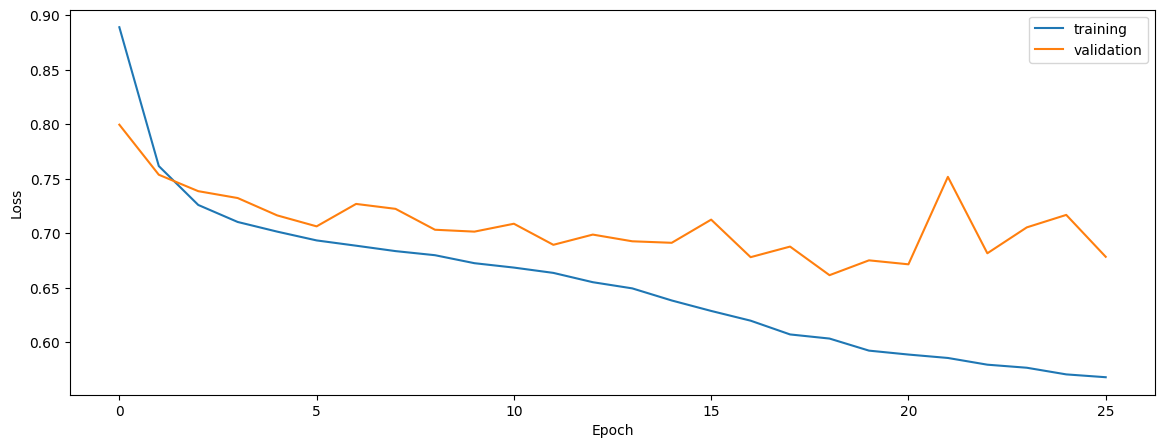

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.7400606134132095


0.7127330601872262


0.7350468981111166


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.7423315333383621


0.7423674615729501


0.7807971853154947


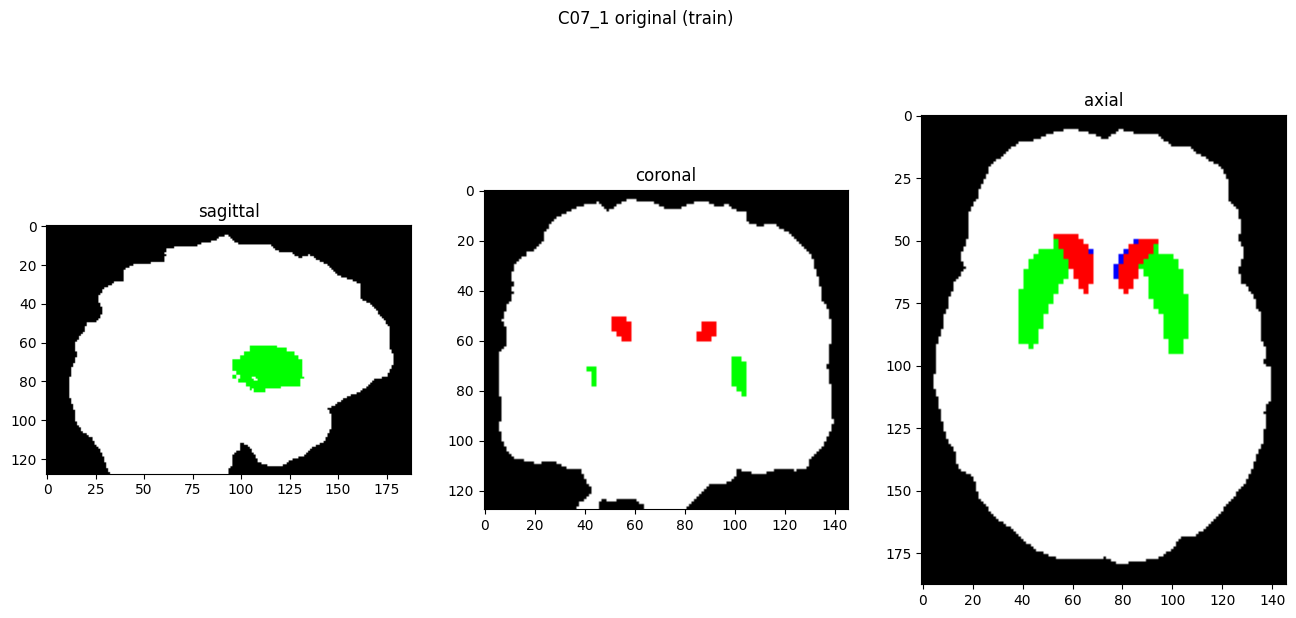

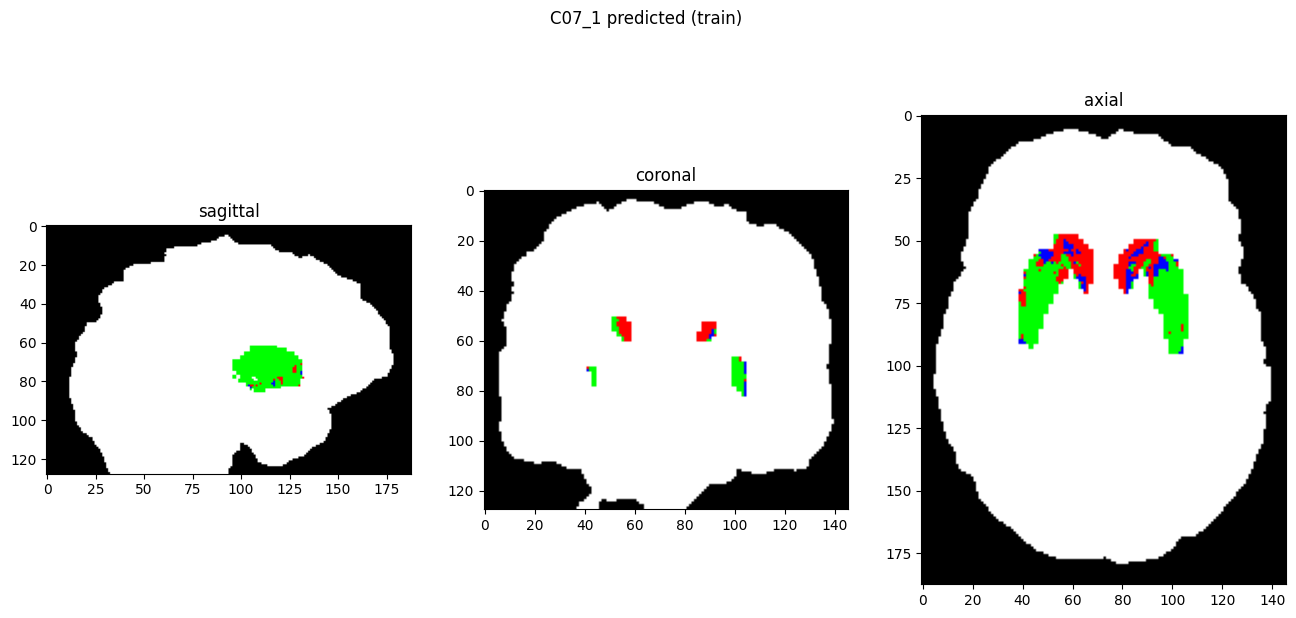

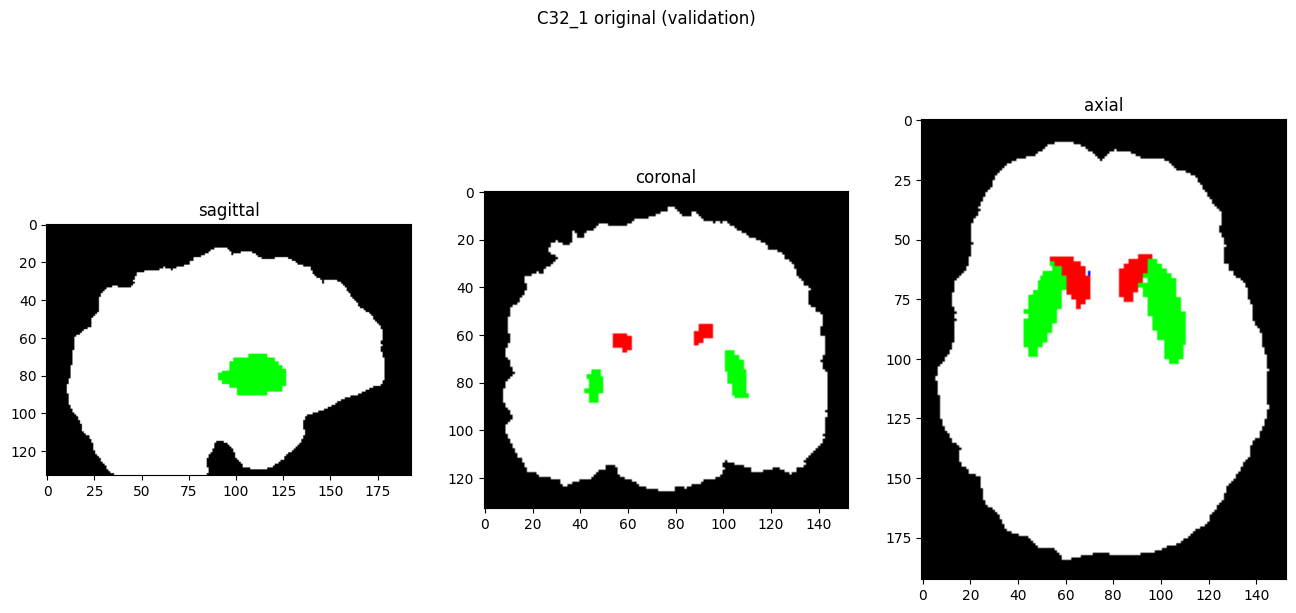

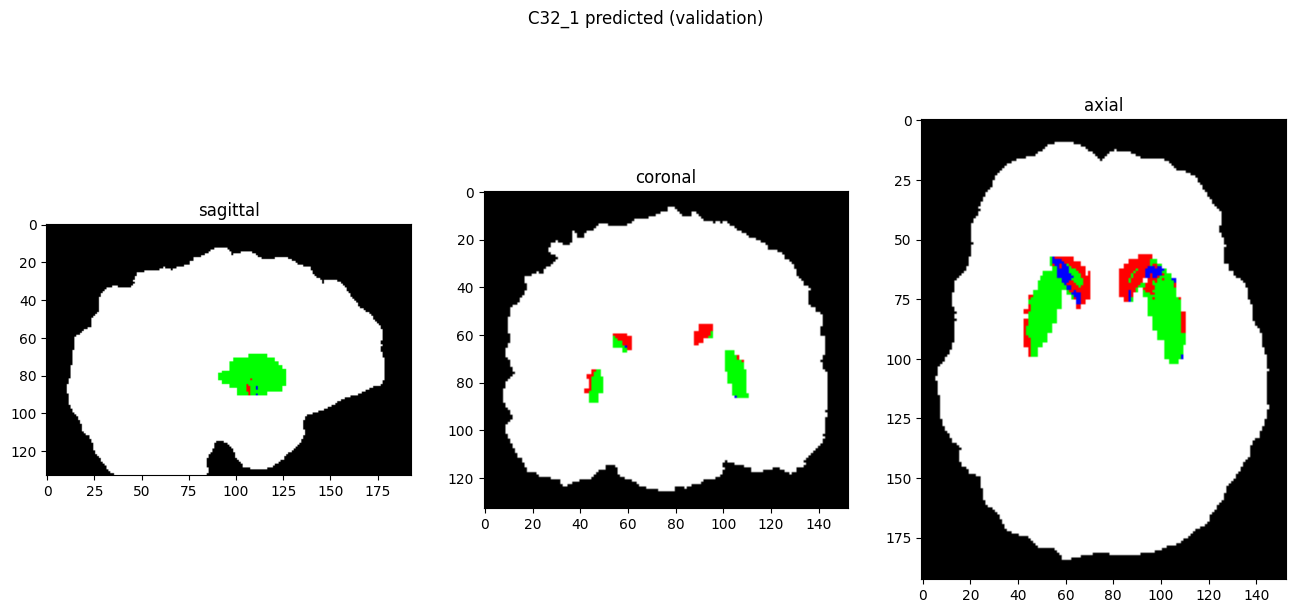

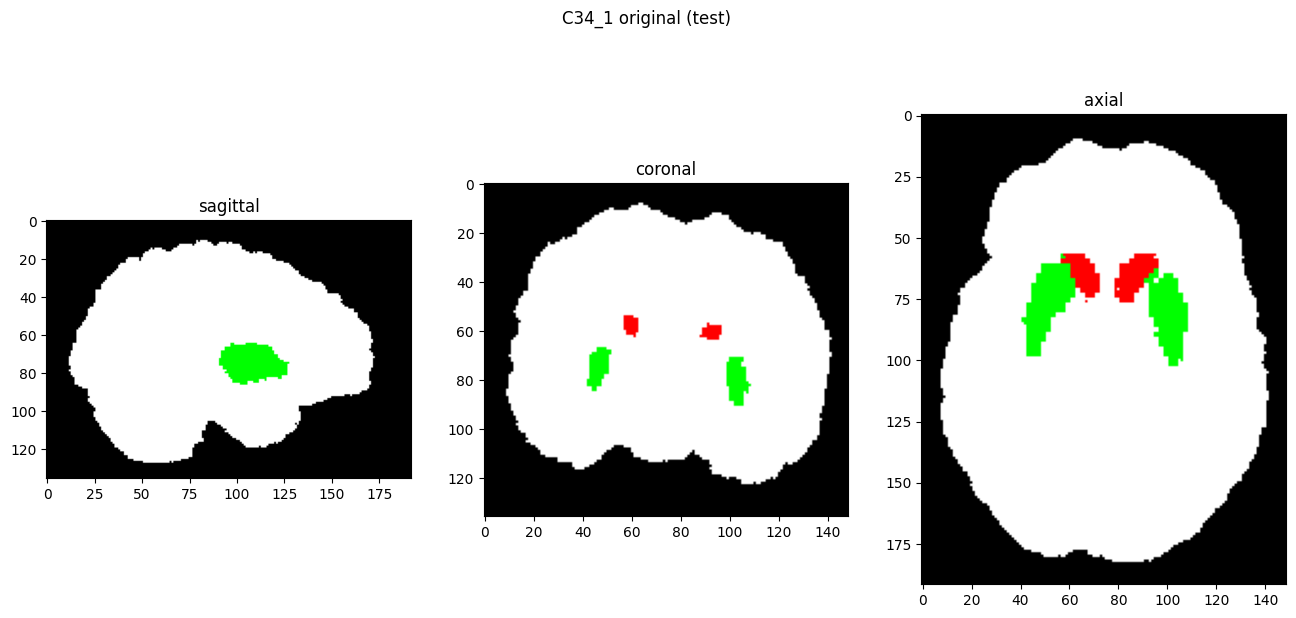

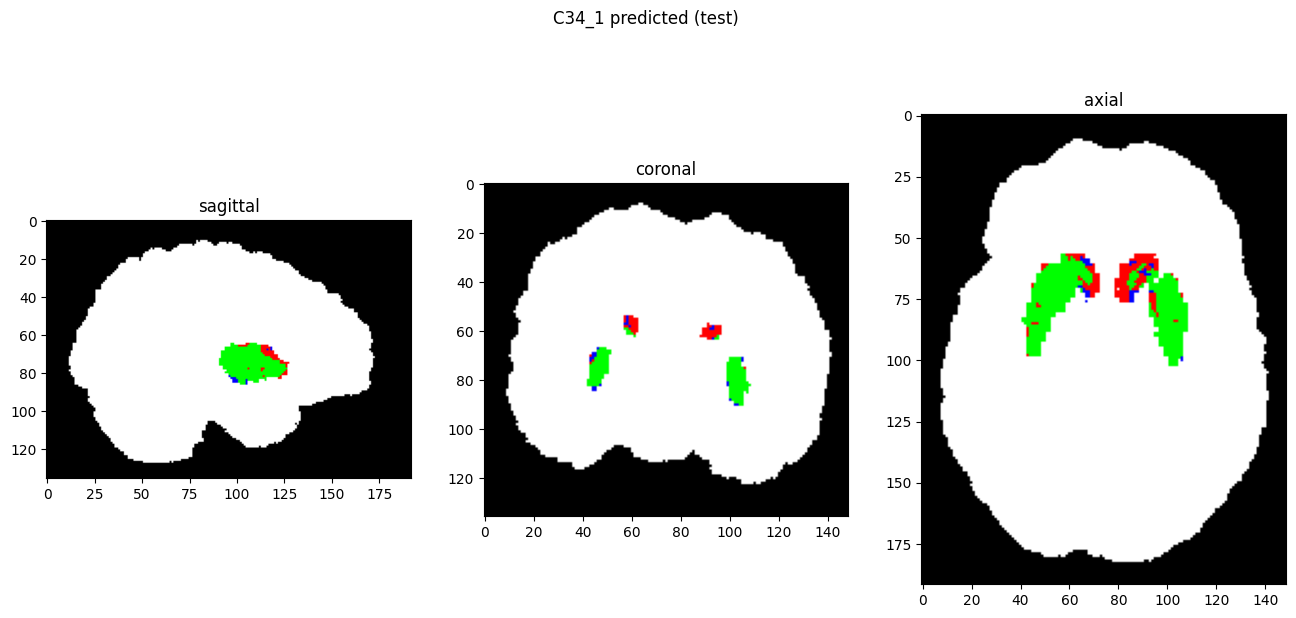

In [9]:
showResults(model, gen, threshold=0)